# Notebook overview

This notebook is a Proof of Concept of a non supervised classification of the products based the Natural Language Processing techniques.

The goal of this part of the project is to demonstrate the possibility to assign a category to each product automatically based on its name and description.

The POC includes the following parts:
1. Import and process dataset
2. A quick exploratory analysis
3. Preprocessing textual data
4. Extracting features using different techniques (Bag of Words, tf-idf, word embedding)
5. Dimensionality reduction, graphic analysis and clustering


# Imports
## Libraries

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import time
import importlib
import utils
importlib.reload(utils)

# preprocessing
import spacy
from nltk.stem import PorterStemmer

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn import preprocessing

# gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

# tensorflow
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


# BERT
from transformers import AutoTokenizer, TFAutoModel

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

sns.set_style('whitegrid', {'grid.linewidth': .05, 'grid.color': '.85'})
sns.set_palette('Set2')

## Data

The data represents a sample extract from the Flipkart product catalogue and does not have any intellectual property issues.

In [ ]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df

# Dataset overview

Checking null values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
df.isnull().mean().sort_values()

uniq_id                   0.0000
crawl_timestamp           0.0000
product_url               0.0000
product_name              0.0000
product_category_tree     0.0000
pid                       0.0000
image                     0.0000
is_FK_Advantage_product   0.0000
description               0.0000
product_rating            0.0000
overall_rating            0.0000
retail_price              0.0010
discounted_price          0.0010
product_specifications    0.0010
brand                     0.3219
dtype: float64

There are few columns having null values, the column that has the most of them is `brand` (32%). The brand might be a valuable information as to the identification of the product category.

<Axes: >

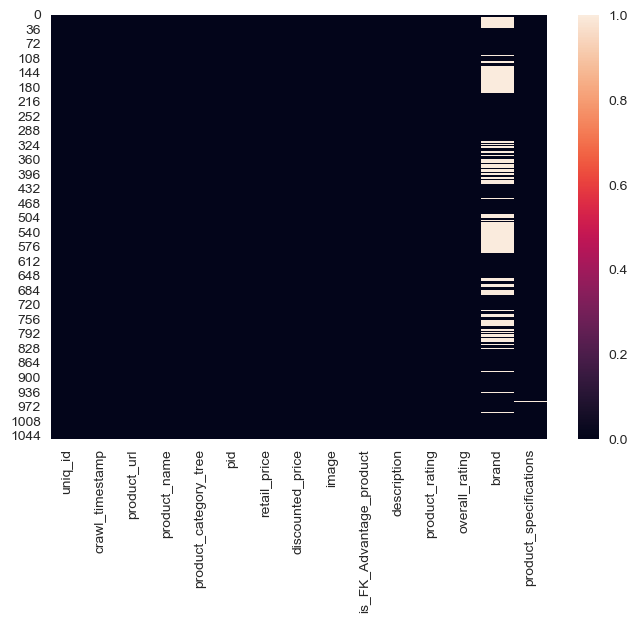

In [5]:
sns.heatmap(df.isnull())

Null values ratio

In [358]:
round(df.isnull().sum().sum() / df.size, 2)

0.02

**Check duplicates**

In [6]:
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

`nunique` method shows the number of unique values per column and allows to spot the duplicates for the features that don't have null values, we see that there are no duplicates for the uniq_id, product_name, pid, image, description.

In [7]:
df.duplicated().sum()

0

Check data by types

In [8]:
df.describe(include=np.number)

retail_price  discounted_price
count     1049.0000         1049.0000
mean      2186.1973         1584.5272
std       7639.2294         7475.0997
min         35.0000           35.0000
25%        555.0000          340.0000
50%        999.0000          600.0000
75%       1999.0000         1199.0000
max     201000.0000       201000.0000

In [9]:
df.describe(include=object)

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   

                                                                                                                       product_url  \
count                                                                                                                         1050   
unique                                                                                                                        1050   
top     http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
freq                                                                                                                             1   

                                                      product_name  \
count                                                         1050   
unique                                                        1050   
top     Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
freq                                                             1   

                                                product_category_tree  \
count                                                            1050   
unique                                                            642   
top     ["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]   
freq                                                               56   

                     pid                                 image  \
count               1050                                  1050   
unique              1050                                  1050   
top     CRNEG7BKMFFYHQ8Z  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq                   1                                     1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         description  \
count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [10]:
df['product_rating'].unique()

array(['No rating available', '5', '1', '2.3', '2.7', '4.5', '4', '3.8',
       '4.3', '3.7', '3.6', '3.5', '4.1', '4.9', '3.1', '4.2', '4.8',
       '4.4', '3.9', '3', '3.3', '2.5', '2', '4.7', '2.2', '3.2', '1.5'],
      dtype=object)

In [11]:
df['overall_rating'].unique()

array(['No rating available', '5', '1', '2.3', '2.7', '4.5', '4', '3.8',
       '4.3', '3.7', '3.6', '3.5', '4.1', '4.9', '3.1', '4.2', '4.8',
       '4.4', '3.9', '3', '3.3', '2.5', '2', '4.7', '2.2', '3.2', '1.5'],
      dtype=object)

**Keep the most relevant features:**

- field for the category extraction (`product_category_tree`)
- textual fields for language processing (`product_name`, `description`)

In [154]:
df_clean = df.copy()
df_clean = df_clean[['product_name', 'product_category_tree', 'description']]
df_clean.head(5)

product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   
2   ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]   
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]   
4             ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in 

# Feature engineering

## Category

### Extracting categories
The category field is presented as a category tree and has the following shape: '["Category level 1 >> Category Level 2 >> Category Level 3 >> ...etc]"', we will work with only one category level for each product

In [ ]:
category_trees = df_clean['product_category_tree'].unique()
print(len(category_trees))
category_trees

All the category tree strings seem to have `[""]` around them, let's see if all them do have these characters

In [ ]:
categories_with_trailing_chars = list(map(lambda x: (x.startswith('["') & x.endswith('"]')), category_trees))
categories_with_trailing_chars

In [157]:
sum(list(filter(lambda x: x, categories_with_trailing_chars)))

642

642 equals the total length of unique category trees, so they all have these characters at the beginning and at the end. We can now define a function that removes these characters, splits the string and return the category from a provided label.

Test the function on a category tree

In [152]:
test_category_tree = '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]'

print(utils.extract_category(test_category_tree, 0)) # should retrun 'Watches'
print(utils.extract_category(test_category_tree, 1)) # should return 'Wrist Watches'
print(utils.extract_category(test_category_tree, 2)) # should return 'Maserati Time Wrist Watches'
print(utils.extract_category(test_category_tree, 3)) # should return 'Maserati Time Wrist Watches'
print(utils.extract_category(test_category_tree, 10)) # should return 'Maserati Time Wrist Watches'

Watches
Wrist Watches
Maserati Time Wrist Watches
Maserati Time Wrist Watches
Maserati Time Wrist Watches


Create new columns for the category 0 and 1 using the function

In [158]:
df_clean['category_0'] = df_clean['product_category_tree'].apply(lambda x: utils.extract_category(x, 0))
df_clean.sample(10)

product_name  \
507                       Rega IT Hp Pavilion DV2535TX DV2536TX 12 Cell 12 Cell Laptop Battery   
478                                             Cotonex Yellow, Green Cotton Kitchen Linen Set   
224  Lal Haveli Traditional Hand Crafted Beautiful Iron Musician 5 Pcs Set Showpiece  -  33 cm   
327                                                                           Edimax BR-6428NC   
200                                                           MA Design Hut Showpiece  -  8 cm   
725                                Craftartz Buddha Brass Idol Dhyan Mudra Showpiece  -  14 cm   
247                                                  Leo Natura Paniarakkal 7 Hole Kadhai NA L   
861                                                             Kensington 33399EU USB USB Hub   
404                                                        Playboy London And Malibu Combo Set   
488                   Rega IT Hp Pavilion DV6-6080SF DV6-6081EI 12 Cell 12 Cell Laptop Battery   

                                                                                                          product_category_tree  \
507                                                       ["Computers >> Laptop Accessories >> Batteries >> Rega IT Batteries"]   
478  ["Home Furnishing >> Kitchen & Dining Linen >> Kitchen Linen Sets >> Cotonex Yellow, Green Cotton Kitchen Linen Set (..."]   
224                                                 ["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Lal Haveli Ethnic"]   
327                                                            ["Computers >> Network Components >> Routers >> Edimax Routers"]   
200                                                    ["Home Decor & Festive Needs >> Showpieces >> MA Design Hut Showpieces"]   
725   ["Home Decor & Festive Needs >> Table Decor & Handicrafts >> Showpieces >> Religious Idols >> Craftartz Religious Idols"]   
247                              ["Kitchen & Dining >> Cookware >> Pots & Pans >> Woks & Kadhais >> Leo Natura Woks & Kadhais"]   
861                                                ["Computers >> Laptop Accessories >> USB Gadgets >> Kensington USB Gadgets"]   
404                                        ["Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Playboy Combos"]   
488                                                       ["Computers >> Laptop Accessories >> Batteries >> Rega IT Batteries"]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Create a column with category 1

In [159]:
df_clean['category_1'] = df_clean['product_category_tree'].apply(lambda x: utils.extract_category(x, 1))
df_clean.sample(10)

product_name  \
839                                       Himtek light led 1 USB Led Light   
246                                                   Peacock Kadhai 3.8 L   
661  Divine Gifts & Artificial Jewellery Shanker Blue Showpiece  -  7.5 cm   
971                            Sparklings Cotton Geometric Double Bedsheet   
415                                Ajmal Titanium and Expedition Combo Set   
741            Fogg Fashion Store 3003-PK Modish Analog Watch  - For Women   
829                                   Fonokase SU100 SU100 USB USB Charger   
942                             The Art Box Floral Single Dohar Multicolor   
373                                    Edimax BR6524N N300 Wireless Router   
930                             Utsav Handicraft UHD004 Showpiece  -  8 cm   

                                                                                                                                   product_category_tree  \
839                                                                             ["Computers >> Laptop Accessories >> USB Gadgets >> Himtek USB Gadgets"]   
246                                                          ["Kitchen & Dining >> Cookware >> Pots & Pans >> Woks & Kadhais >> Peacock Woks & Kadhais"]   
661  ["Home Decor & Festive Needs >> Table Decor & Handicrafts >> Showpieces >> Religious Idols >> Divine Gifts & Artificial Jewellery Religious Idols"]   
971                  ["Baby Care >> Baby Bedding >> Baby Bedsheets >> Sparklings Baby Bedsheets >> Sparklings Cotton Geometric Double Bedsheet (dou..."]   
415                                                                   ["Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Ajmal Combos"]   
741                                                                                     ["Watches >> Wrist Watches >> Fogg Fashion Store Wrist Watches"]   
829                                                                           ["Computers >> Laptop Accessories >> USB Gadgets >> Fonokase USB Gadgets"]   
942                                                                                        ["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]   
373                                                                                     ["Computers >> Network Components >> Routers >> Edimax Routers"]   
930                     ["Home Decor & Festive Needs >> Table Decor & Handicrafts >> Showpieces >> Religious Idols >> Utsav Handicraft Religious Idols"]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [160]:
df_clean = df_clean.drop(columns='product_category_tree')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  1050 non-null   object
 1   description   1050 non-null   object
 2   category_0    1050 non-null   object
 3   category_1    1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB


### Quick analysis

Check categories number and how many products does each category contain

In [20]:
df_clean[['category_0', 'category_1']].nunique()

category_0     7
category_1    62
dtype: int64

We get 7 first-level categories and 62 second-level categories

**Category 0**

In [161]:
c0_counts = df_clean['category_0'].value_counts()
c0_percs = df_clean['category_0'].value_counts(normalize=True)
pd.concat([c0_counts, c0_percs], axis=1, keys=['count', 'percentage'])

count  percentage
category_0                                   
Home Furnishing               150      0.1429
Baby Care                     150      0.1429
Watches                       150      0.1429
Home Decor & Festive Needs    150      0.1429
Kitchen & Dining              150      0.1429
Beauty and Personal Care      150      0.1429
Computers                     150      0.1429

We see exactly 150 items in each category

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


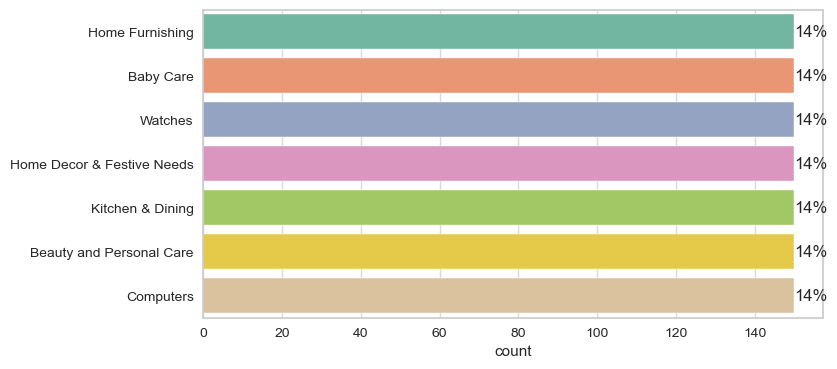

In [368]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.countplot(y=df_clean['category_0'],
              order=df_clean['category_0'].value_counts().index, ax=ax)

ax.bar_label(
    ax.containers[0], fmt=lambda x: '{:.0f}%'.format(
        x/df_clean.shape[0]*100)
)

plt.ylabel(ylabel=None)
plt.show()


**Category 1**

In [163]:
c1_counts = df_clean['category_1'].value_counts()
c1_percs = df_clean['category_1'].value_counts(normalize=True)
pd.concat([c1_counts, c1_percs], axis=1, keys=['count', 'percentage']
          ).sort_values('count', ascending=False).head(20)

count  percentage
category_1                                  
Wrist Watches                149      0.1419
Laptop Accessories            87      0.0829
Infant Wear                   84      0.0800
Coffee Mugs                   74      0.0705
Showpieces                    71      0.0676
Bed Linen                     65      0.0619
Fragrances                    65      0.0619
Network Components            49      0.0467
Cookware                      27      0.0257
Table Decor & Handicrafts     27      0.0257
Combos and Kits               24      0.0229
Wall Decor & Clocks           22      0.0210
Bath Linen                    21      0.0200
Curtains & Accessories        19      0.0181
Makeup                        18      0.0171
Baby & Kids Gifts             15      0.0143
Baby Bedding                  15      0.0143
Body and Skin Care            15      0.0143
Baby Bath & Skin              14      0.0133
Kitchen Tools                 14      0.0133

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


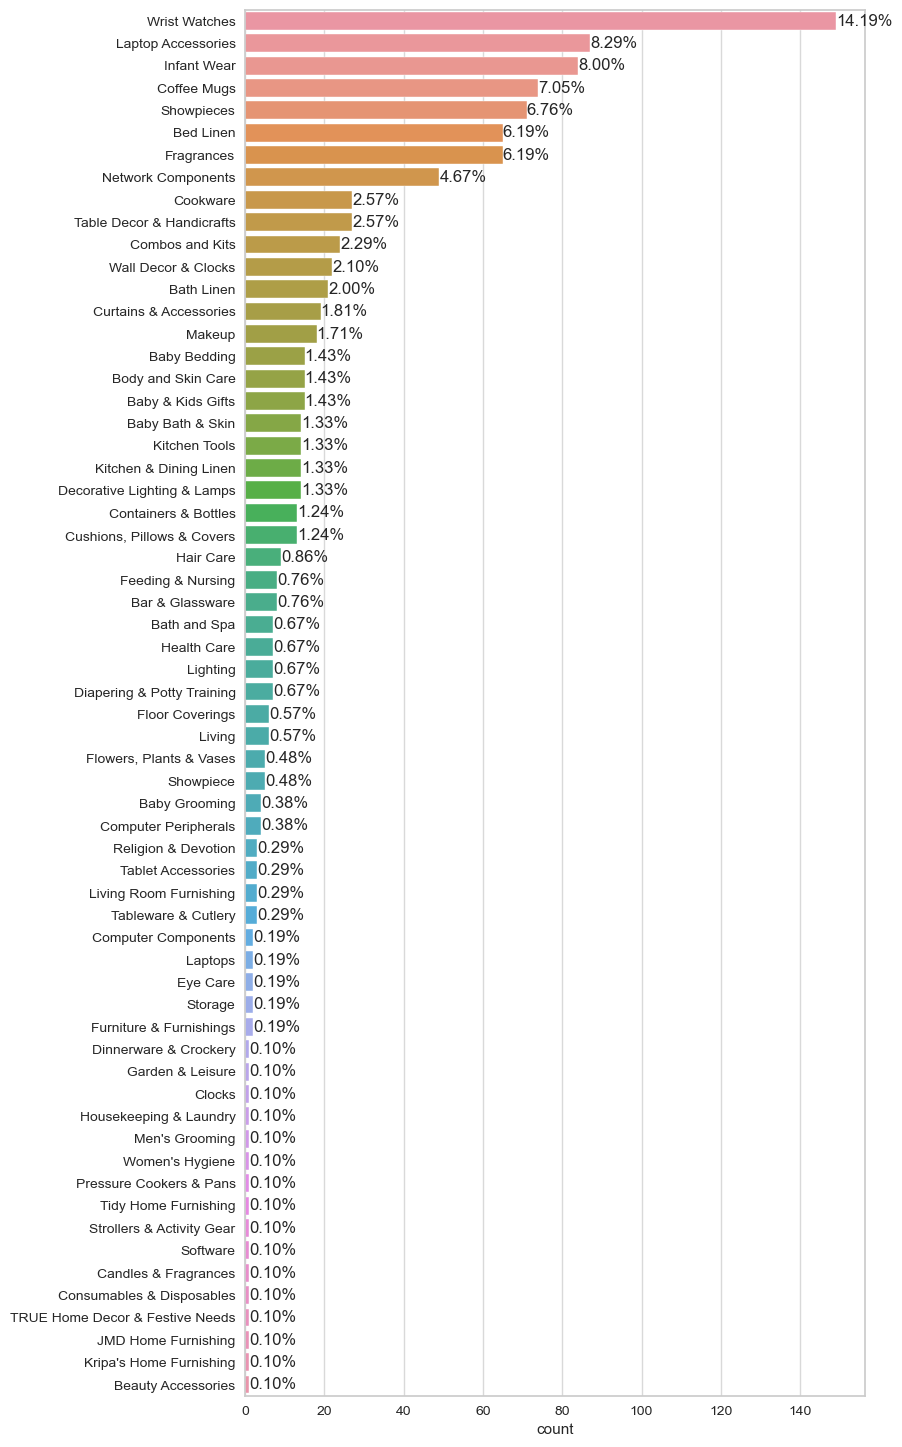

In [164]:
top_category_1 = df_clean['category_1'].value_counts().sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8, 18))

sns.countplot(y=df_clean['category_1'], order=df_clean['category_1'].value_counts().index, ax=ax)

ax.bar_label(
    ax.containers[0], fmt=lambda x: '{:.2f}%'.format(
        x/df_clean.shape[0]*100)
)

plt.ylabel(ylabel=None)
plt.show()

Check the number of sub categories in the main category

In [165]:
df_cat_grouped = df_clean.groupby('category_0')[
    'category_1'].nunique().reset_index().sort_values('category_1')
df_cat_grouped

category_0  category_1
6                     Watches           2
2                   Computers           8
0                   Baby Care           9
3  Home Decor & Festive Needs          10
1    Beauty and Personal Care          11
4             Home Furnishing          11
5            Kitchen & Dining          11

## Product name + description

We'll merge the product name and the description columns in order to have only 1 text field to work with.

In [166]:
df_clean['full_description'] = df_clean['product_name'] + ' ' + df_clean['description']
df_clean

product_name  \
0            Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                            Sathiyas Cotton Bath Towel   
2                                   Eurospa Cotton Terry Face Towel Set   
3       SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4                 Jaipur Print Cotton Floral King sized Double Bedsheet   
...                                                                 ...   
1045                     Oren Empower Extra Large Self Adhesive Sticker   
1046                             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker   
1048                            Wallmantra Medium Vinyl Sticker Sticker   
1049                                       Uberlyfe Large Vinyl Sticker   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# Data exploring 

We'll perform a quick exploratory analysis in order to better understand the data

## Text length

Let's calculate the length of each text feature

In [ ]:
df_clean['product_name_len'] = df_clean['product_name'].str.len()
df_clean['description_len'] = df_clean['description'].str.len()
df_clean['full_description_len'] = df_clean['full_description'].str.len()
df_clean

In [169]:
df_clean[['product_name_len', 'description_len', 'full_description_len']].describe()

product_name_len  description_len  full_description_len
count         1050.0000        1050.0000             1050.0000
mean            45.1019         473.8210              519.9229
std             17.4973         457.9104              461.2837
min              8.0000         109.0000              131.0000
25%             33.0000         192.0000              233.0000
50%             43.0000         278.0000              336.0000
75%             55.0000         588.2500              636.0000
max            151.0000        3490.0000             3519.0000

The length of full description goes from 131 to 3519 characters with an average of 520 characters

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


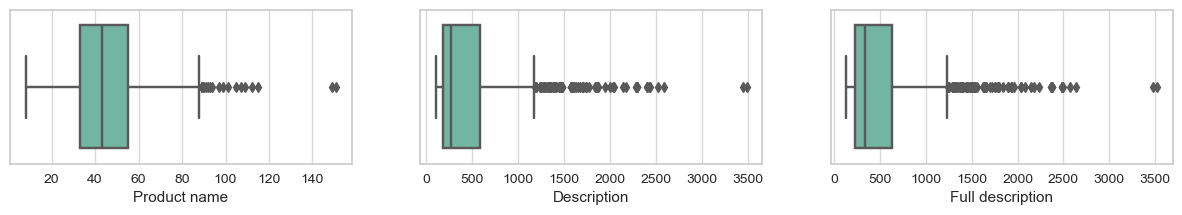

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 2))

sns.boxplot(x=df_clean['product_name_len'], ax=ax1)
ax1.set(xlabel='Product name')

sns.boxplot(x=df_clean['description_len'], ax=ax2)
ax2.set(xlabel='Description')

sns.boxplot(x=df_clean['full_description_len'], ax=ax3)
ax3.set(xlabel='Full description')

plt.show()

Let's check how the text length varies depending on the category:

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


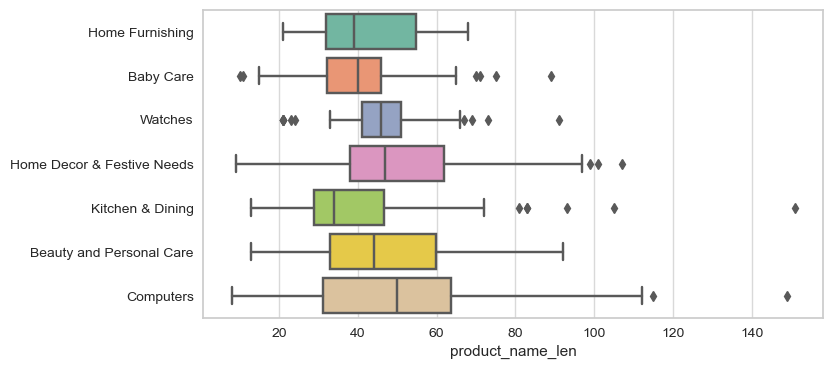

In [31]:
plt.figure(figsize=(8, 4))

sns.boxplot(data=df_clean, x='product_name_len', y="category_0")

plt.ylabel(ylabel='')
plt.show()

From the box plot above we don't observe huge differencies in the product names lenghts of the categories, the longest product names however are in 'Kitchen and Dining' and 'Computers' categories

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


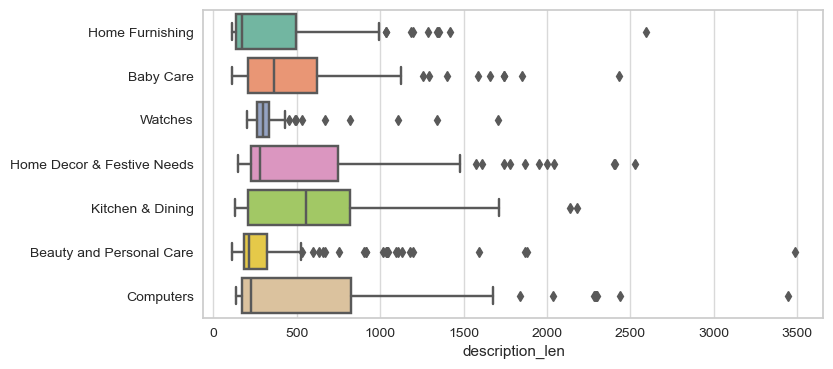

In [32]:
plt.figure(figsize=(8, 4))

sns.boxplot(data=df_clean, x='description_len', y="category_0")

plt.ylabel(ylabel='')
plt.show()

We can see from the plot above that 'Watches' descriptions are the least verbose, 'Computers', 'Kitchen and Dining', 'Home Decore and Festive Needs' are those who have the longest descriptions.


Let's check if there is any relation between the lengths of product names and descriptions

In [33]:
correlations = df_clean[['product_name_len', 'description_len', 'full_description_len']].corr()
correlations

product_name_len  description_len  full_description_len
product_name_len                1.0000           0.1744                0.2110
description_len                 0.1744           1.0000                0.9993
full_description_len            0.2110           0.9993                1.0000

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


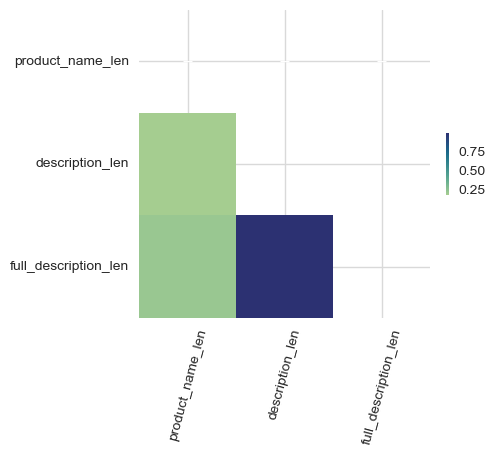

In [34]:
mask = np.zeros_like(correlations, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(4, 4))
corr_heatmap = sns.heatmap(correlations,
                           cbar_kws={'fraction': 0.01},
                           mask=mask,
                           annot=True,
                           cmap="crest"
                           )
plt.xticks(rotation=75)
plt.yticks(rotation=0)
corr_heatmap.set(xlabel="", ylabel="")
plt.show()

Without surprise, the lengths of description and full description are correlated as the description takes the biggest part of the full description. We have a really small correlation between the product name length and its description.

## WordCloud for categories

In order to have a better understanding on the cleaning operations to perform, we need to give a closer look on the content presented in the products description for each category.

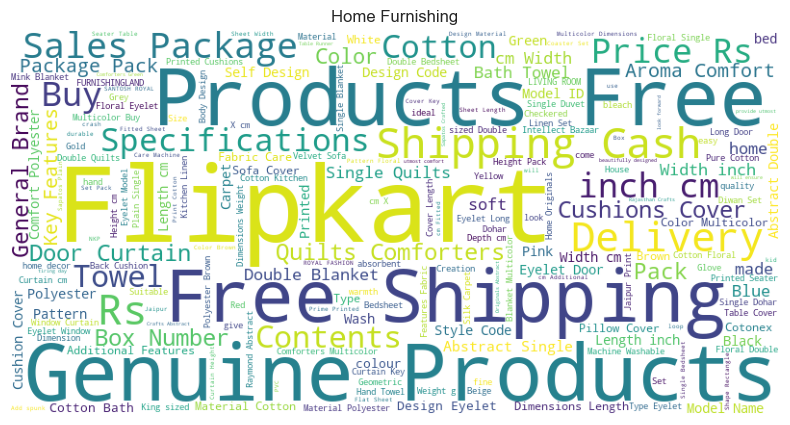

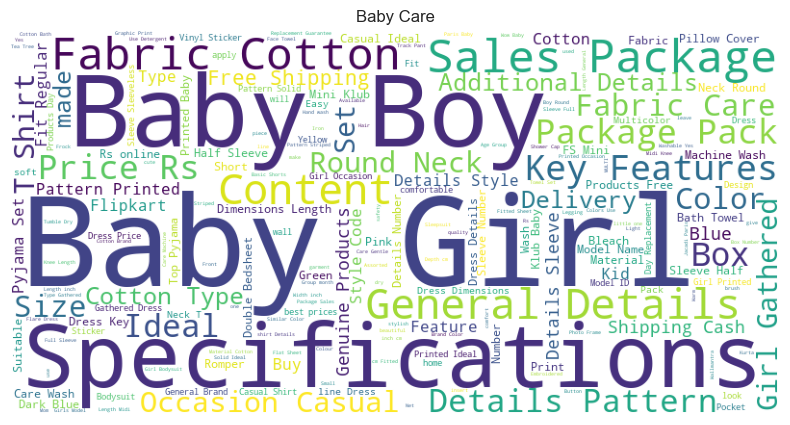

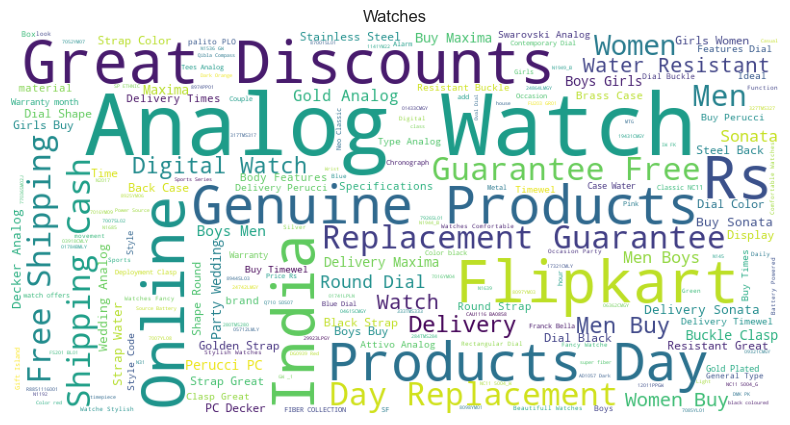

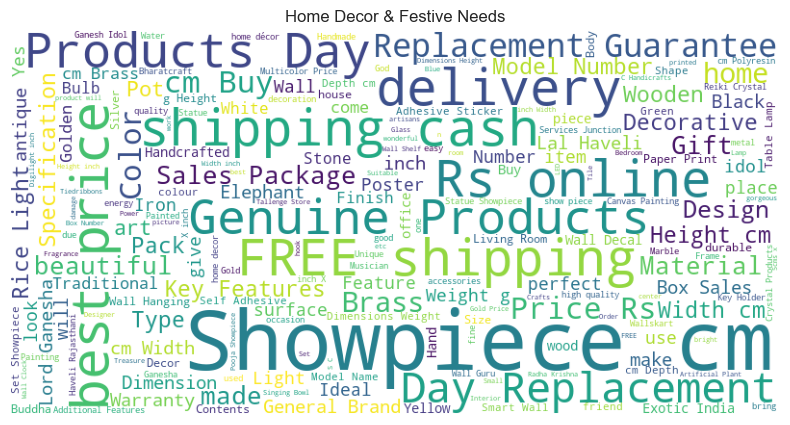

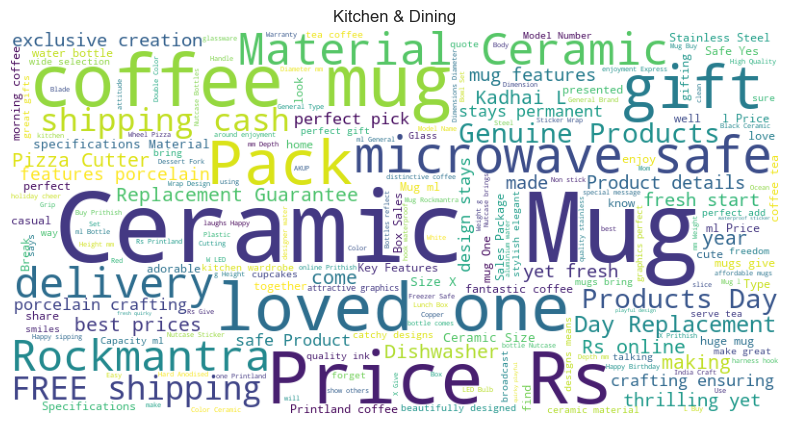

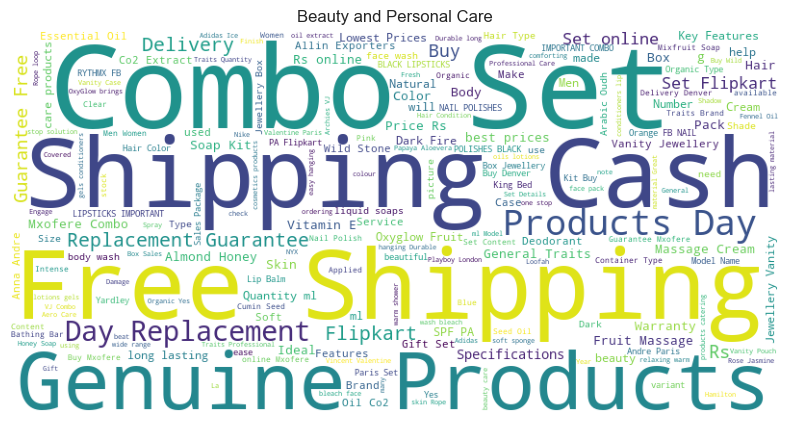

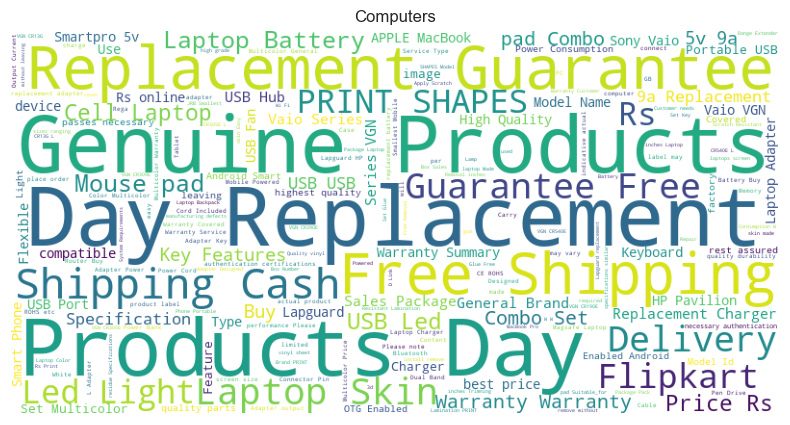

In [170]:
categories = df_clean['category_0'].unique()

for category in categories:
    descriptions = df_clean[df_clean['category_0'] == category ]['full_description']
    
    fig, ax = plt.subplots(figsize=[10, 5])

    wordcloud = WordCloud( background_color='white',
                            width=800,
                            height=400).generate(" ".join(descriptions))
    ax.imshow(wordcloud)
    ax.axis('off')
    ax.set_title(category,fontsize=12)
    plt.show()

We can define several group of word categories from the word clouds above:

1. High frequency words and bi-gramms specific for the category
2. High frequency words and bi-gramms that are more general and can be applied to different catefories


For example, bi-grams like 'Genuine Products', 'Free Shipping', 'Shipping Cash', 'Day replacement' and others appear in almost every category but they are pretty generic and don't bring any value.

# Text cleaning

The text cleaning will be done in several steps:
1. Understand the cleaning operations to perform
2. Technical cleaning which will focus on transforming text to lowercase, removing ponctuation, stop words, etc
3. Semantic cleaning which will remove tokens that don't bring any particular value to the category


In [36]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   uniq_id               1050 non-null   object
 1   product_name          1050 non-null   object
 2   description           1050 non-null   object
 3   category_0            1050 non-null   object
 4   category_1            1050 non-null   object
 5   full_description      1050 non-null   object
 6   product_name_len      1050 non-null   int64 
 7   description_len       1050 non-null   int64 
 8   full_description_len  1050 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 74.0+ KB


For the following steps of text cleaning and preprocessing we will need to remove irrelevant columns and keep only necessary ones like our main text column and category

In [37]:
df_to_process = df_clean.copy()
df_to_process = df_to_process[['category_0', 'category_1', 'full_description']]
df_to_process.head(5)

category_0              category_1  \
0  Home Furnishing  Curtains & Accessories   
1        Baby Care        Baby Bath & Skin   
2        Baby Care        Baby Bath & Skin   
3  Home Furnishing               Bed Linen   
4  Home Furnishing               Bed Linen   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          full_description  
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## Exploring text

In order to have a better understanding on the cleaning operations to perform, we need to give a closer look on the content presented in the products description.

In [171]:
sample = df_to_process.sample(10)

for index in sample.index: 
    print(sample['category_0'][index])
    print(sample['full_description'][index])
    print('-----------------------')

Home Furnishing
Fabutex Polyester Black, White Abstract Eyelet Window & Door Curtain Fabutex Polyester Black, White Abstract Eyelet Window & Door Curtain (214 cm in Height, Pack of 4)
                         Price: Rs. 2,696
				
			High Quallity polyester jacquard Curtains, which adds a rich feel and fills your home with warmth of love and coziness. Exclusively from the house of fabutex.
High Quallity polyester jacquard Curtains, which adds a rich feel and fills your home with warmth of love and coziness. Exclusively from the house of fabutex.
-----------------------
Kitchen & Dining
GAYATRI CREATIONS ORANGE KIDS SET 2 Containers Lunch Box Specifications of GAYATRI CREATIONS ORANGE KIDS SET 2 Containers Lunch Box (400 ml) General Series BEST OF LUCK Model Name ORANGE KIDS SET Lunch Box Features Lunch Box Material Plastic Number of Containers 2 Lunch Box Capacity 400 ml In the Box 1 LUNCH BOX, 1 WATER BOTTLE
-----------------------
Beauty and Personal Care
Nike Casual Combo Set Flipka

Keyboard characters:
- carriage return (\n, \n\r)
- tabulations (\t)

Common words:
- Great Discounts
- Only Genuine Products
- 30 Day Replacement Guarantee
- Free Shipping
- Cash On Delivery
- Price in rupee (Rs. + price)
- Photos
- Height
- Weight
- Flipkart.com
- Flipkart
- Product details
- Ideal
- dimensions
- diameter
- buy
- Life Time Warranty world widw 
- Not Covered in Warranty 
- Physical Damage

Odd words:
- words containing 1 letter

Other elements to question:
- prices
- product identification numbers
- product dimensions (in inches)
- photo size

## Technical cleaning

At this step we'll perform a "technical" cleaning with the spacy library:
- convert to lower case
- keep alpha characters
- remove stop words
- remove punctuation
- remove 1-letter words
- lemmatize

In [40]:
nlp = spacy.load('en_core_web_sm')

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


**Check the stop words**

In [ ]:
nlp.Defaults.stop_words

Some words might be userful, like 'top' that can refer to a piece of cloth

In [ ]:
nlp.Defaults.stop_words -= {"top"}
nlp.Defaults.stop_words

**Stemming and lemmatization**

**Stemming** and **Lemmatization** are text normalization techniques that are used to prepare textual data for further processing.
Both techniques aim to reduce derived and inflected words to a common root, but they do in different ways:

1. **Stemming** removes the last few characters of a given word to obtain a shorter form, even if that form doesn’t have any meaning. For example, 'history' and 'historical' will give 'histori'.
2. **Lemmatization** considers the context and converts the word to its meaningful base form, which is called lemma. For example, a lemma for 'caring' would be 'care' (and not 'car' as in stemming)

Let's see both techniques in action:

In [172]:
def tokenize(document):
    """
    Transforms a given document to a list of tokens using spacy library

    Input: 
        document: string to process

    Output:
        tokens: list of tokens
    """

    # init spaCy doc object
    doc = nlp(document)

    return [token for token in doc]

test_document = "Give me tokens out of this document"
tokenize(test_document)

[Give, me, tokens, out, of, this, document]

In [176]:
# lemmatization
def lemmatise_doc(document):
    """
    Perform a lemmatisation of a document
    
    Input: 
        document: string to process
        
    Output:
        lemmatised_document: lemmatised string
    """
    
    # turn to lowercase
    lowercase_document = document.lower()
    
    # tokenize
    tokens = tokenize(lowercase_document)
    
    # lemmatize tokens
    tokens = [token.lemma_ for token in tokens]
    
    return " ".join(tokens)

In [175]:
# Test the lemmatise_doc function with a random text
random_desc = "absorbency absorbent ability I am able youthful youth we are young"

print('Before')
print('--------')
print(random_desc)
print(' ')
print('After')
print('--------')
print(lemmatise_doc(random_desc))

Before
--------
absorbency absorbent ability I am able youthful youth we are young
 
After
--------
absorbency absorbent ability I be able youthful youth we be young


'am' and 'are' were transformed to 'be', however, the other words stayed unchanged

In [179]:
# stemming
def stem_doc(document):
    """
    Perform a stemming of a document
    
    Input: 
        document: string to process
        
    Output:
        stemmed_document: stemmed string
    """
    
    # tokenize
    tokens = tokenize(document)
    
    # instantiate a stemmer
    ps = PorterStemmer()
    
    # stem the tokens
    stems = [ps.stem(token.text, to_lowercase=True) for token in tokens]
    
    return " ".join(stems)

In [181]:
# Test the stem_doc function with a random text
random_desc = "absorbency absorbent ability I am able youthful youth we are young"

print('Before')
print('--------')
print(random_desc)
print(' ')
print('After')
print('--------')
print(stem_doc(random_desc))

Before
--------
absorbency absorbent ability I am able youthful youth we are young
 
After
--------
absorb absorb abil i am abl youth youth we are young


Contrary to the lemmatization, stemming reduced 'youthful' and 'youth' to 'youth' but didn't include 'young', 'absorbency' and 'absorbent' to 'absorb', it didn't transform 'am' and 'are', and didn't find the common root for 'ability' and 'able'.

**Lemmatization** gives more meaningful results while **stemming** automatically cuts the words. However, **lemmatization** is computationally expensive since it involves looking up in WordNet corpus to understand the context, while **stemming** does not. **Stemming** might be used for large amount of documents where performance is an issue, in our case, we only have 1050 documents so we would prefer a more efficient way to normalize the text (lemmatization)

In [183]:
def processDocument(document):
    """This function performs a number of operations on the given document with the spacy library:
        - converts to lowercase
        - tokenizes the document
        - removes stopwords
        - removes punctuation marks
        - removes non alpha characters
        - lemming
        - removes words that contain only 1 letter
    
    Input: 
        document: string to process
        
    Output:
        cleaned_document: processed string
        
    """
    # turn to lowercase
    lowercase_document = document.lower()
    
    # tokenize
    tokens = tokenize(lowercase_document)
    
    # exclude stop words
    tokens = [token for token in tokens if not token.is_stop]
    
    # remove punctuation
    tokens = [token for token in tokens if not token.is_punct]
    
    # remove non alpha characters
    tokens = [token for token in tokens if token.is_alpha]
    
    # lemmatize tokens
    tokens = [token.lemma_ for token in tokens]
    
    # remove 1 letter words
    tokens = [token for token in tokens if len(token) > 1]
    
    return " ".join(tokens)

In [184]:
# Test the processDocument function with a random description
random_desc = df_to_process.sample(1)['full_description'].to_string(index=False)

print('Before')
print('--------')
print(random_desc)
print(' ')
print('After')
print('--------')
print(processDocument(random_desc))

Before
--------
Lotus Safe Sun UV Screen MatteGel - SPF 50 PA+++ Flipkart.com: Buy Lotus Safe Sun UV Screen MatteGel - SPF 50 PA+++ for Rs. 340 from Flipkart.com. - Lowest Prices, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
 
After
--------
lotus safe sun uv screen mattegel spf buy lotus safe sun uv screen mattegel spf rs low price genuine product day replacement guarantee free shipping cash delivery


Add a column with a processed description to the dataframe

In [ ]:
start = time.time()

df_to_process['description_processed'] = df_to_process['full_description'].map(lambda x: processDocument(x))
exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

df_to_process

In [186]:
def get_text_len_difference(text_column_from, text_column_to):
    """
    Return the percentage of text reduced
    
    Input:
        text_column_from: dataframe column with original text
        text_column_to: dataframe column with modified text
        
    Output:
        text_reduced: string with a text message containing the reduction size in percentage
    """
    
    text_from = " ".join(text_column_from)
    text_to = " ".join(text_column_to)
    
    text_from_len = len(text_from)
    text_to_len = len(text_to)
    
    length_diff = text_from_len - text_to_len
    
    length_diff_pc = round(length_diff / text_from_len * 100, 2)
    
    return f'The original text was reduced by {length_diff_pc} % (from {text_from_len} to {text_to_len} chars)'

In [187]:
get_text_len_difference(df_to_process['full_description'], df_to_process['description_processed'])

'The original text was reduced by 29.54 % (from 546968 to 385408 chars)'

## Semantic cleaning

In this iteration we will have a more detailed look on the words present in each category and in the entire corpus. We will mainly focus on spotting and removing:

1. "noise" most frequently used words that don't bring a specific semantic value.
2. rare words

**Most frequent words in corpus**

These words do not add any meaningful information to the text, and their presence can actually create noise in the data, making it harder to extract useful insights.

Let's use CountVectorizer to get those words

In [188]:
count_vect_max = CountVectorizer()
count_matrix = count_vect_max.fit_transform(df_to_process['description_processed'])

sum_tokens = count_matrix.sum(axis=0) 
tokens_most_freq = [(token, sum_tokens[0, idx]) for token, idx in count_vect_max.vocabulary_.items()]
tokens_most_freq = sorted(tokens_most_freq, key = lambda x: x[1], reverse=True)

tokens_most_freq[:40]

[('product', 865),
 ('cm', 655),
 ('free', 622),
 ('buy', 584),
 ('replacement', 568),
 ('delivery', 567),
 ('genuine', 564),
 ('shipping', 564),
 ('cash', 564),
 ('price', 561),
 ('day', 556),
 ('mug', 533),
 ('rs', 523),
 ('watch', 501),
 ('guarantee', 473),
 ('set', 442),
 ('baby', 415),
 ('feature', 407),
 ('design', 399),
 ('online', 396),
 ('analog', 393),
 ('color', 387),
 ('cotton', 353),
 ('pack', 340),
 ('print', 337),
 ('type', 325),
 ('girl', 313),
 ('showpiece', 312),
 ('box', 308),
 ('material', 306),
 ('ceramic', 297),
 ('general', 288),
 ('laptop', 273),
 ('good', 272),
 ('package', 271),
 ('specification', 270),
 ('sale', 262),
 ('man', 262),
 ('warranty', 252),
 ('boy', 251)]

In [189]:
df_token_corpus = pd.DataFrame(tokens_most_freq, columns=['token', 'count'])
df_token_corpus

token  count
0         product    865
1              cm    655
2            free    622
3             buy    584
4     replacement    568
...           ...    ...
4091   negativity      1
4092         main      1
4093       rotate      1
4094    clockwise      1
4095    intention      1

[4096 rows x 2 columns]

<Axes: title={'center': 'Top 40 most frequent words in corpus'}, xlabel='token'>

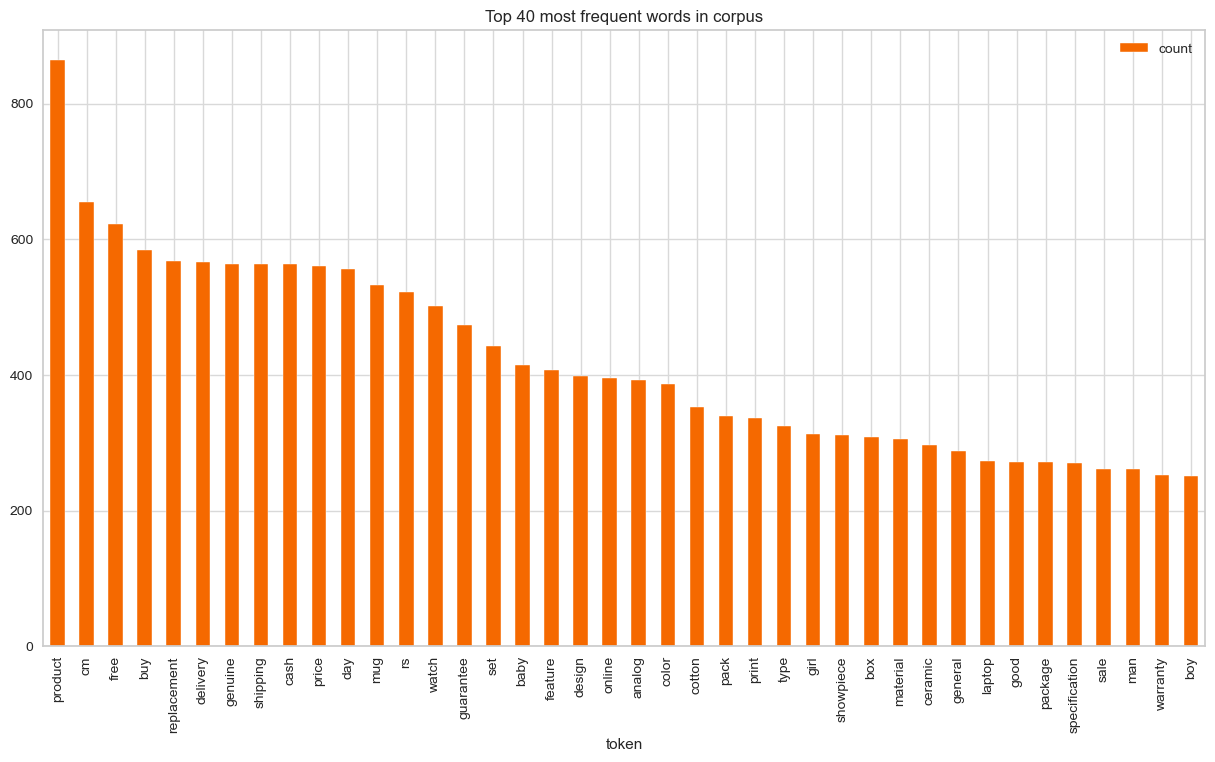

In [190]:
df_token_corpus.head(40).plot(kind='bar', x='token', y='count', color="#f56900",
                              title=f'Top 40 most frequent words in corpus', figsize=(15, 8))

We can spot words like:

- product
- cm
- free
- buy
- replacement
- delivery
- genuine
- guarantee
- shipping
- cash
- price
- day
- rs
- set
- pack
- general
- feature
- online
- type 
- general
- good
- package
- specification
- sale
- showpiece
- material

Those words don't bring any particular meaning to the products, they can be removed.

However, the words like 'watch', 'mug', 'baby', 'analog', 'cotton', 'ceramic', 'laptop' are meaningful and are certainly used in specific categories.

**Most frequent words in categories**

In [191]:
def create_category_freq_dict(df, category):
    """ 
    Creates a dictionary with a frequency dictionary per category
    
    Input:
        df: dataframe
        category: category feature name ('category_0', 'category_1')
        
    Output:
        categories_desc_freqs: dictionary of the following shape:
            {
                'category_name':
                    {
                        'token1_name': token1_count,
                        'token2_name': token2_count,
                        ...
                    }
            }
    """
    categories = df['category_0'].unique()

    categories_desc_freqs = {}

    for category in categories:
        # concatenate description for each category
        category_descriptions = df[df['category_0'] == category ]['description_processed']
        category_description = " ".join(category_descriptions)

        # build a dictionary with the tokens frequency
        freqs = {}
        category_doc = nlp(category_description)

        for token in category_doc:
            if token.text in freqs:
                freqs[token.text] += 1
            else:
                freqs[token.text] = 1

        categories_desc_freqs[category] = freqs
        
    return categories_desc_freqs

In [ ]:
categories_desc_freqs = create_category_freq_dict(df_to_process, 'category_0')
categories_desc_freqs

Get a graph representing the most frequent words

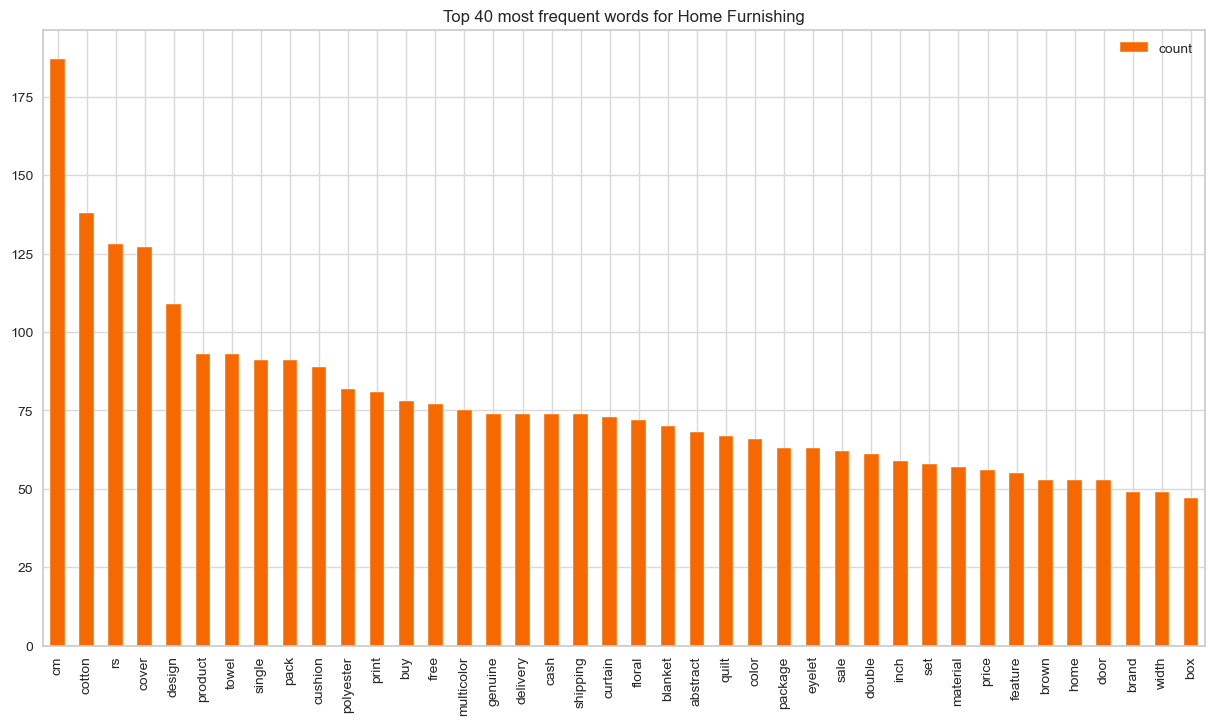

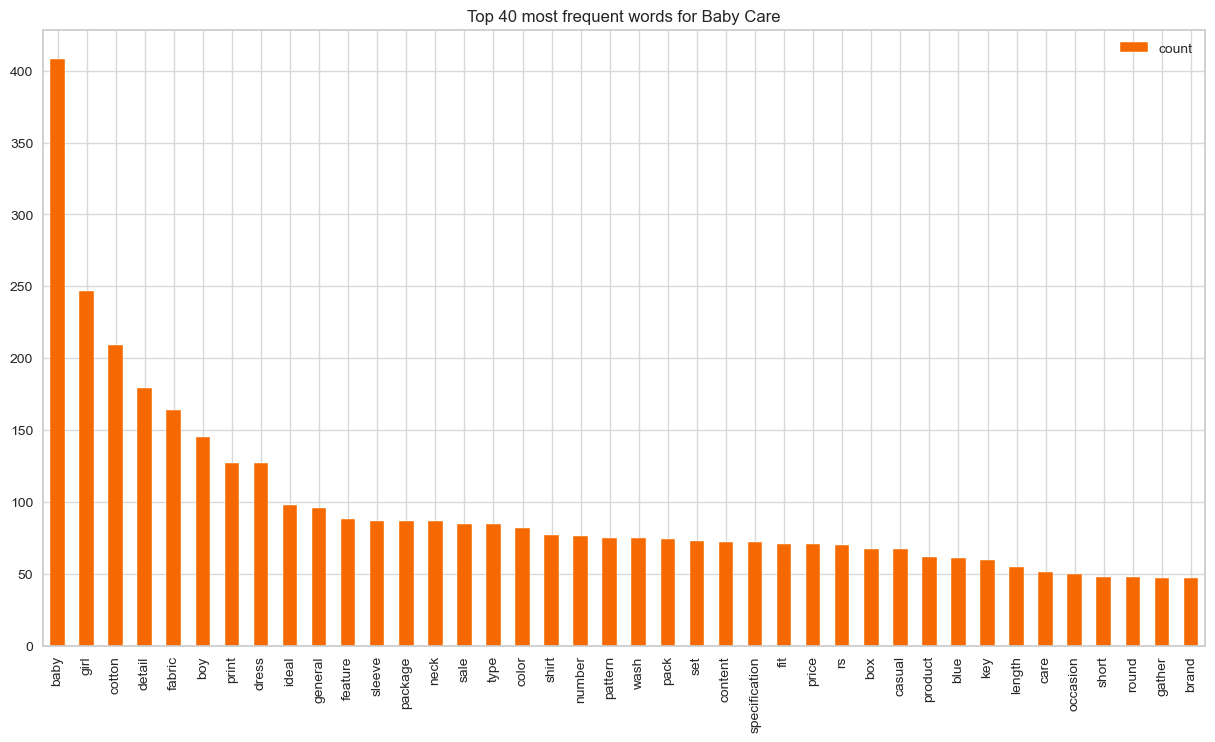

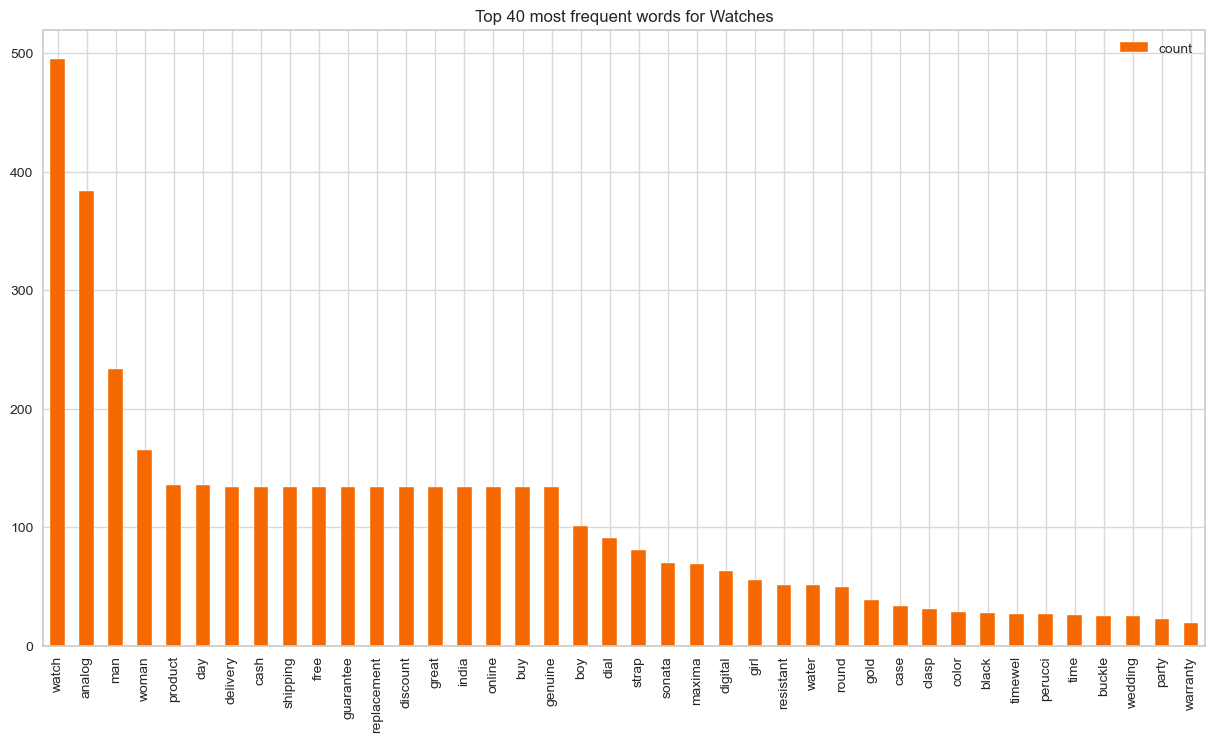

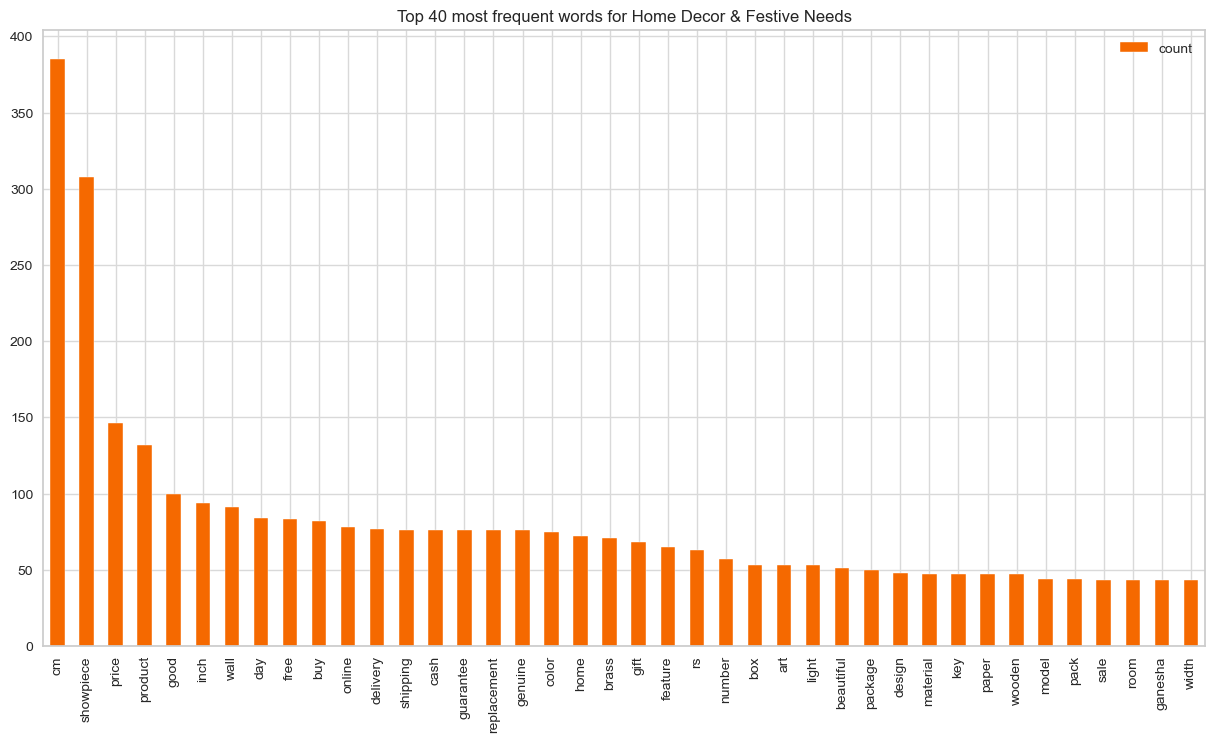

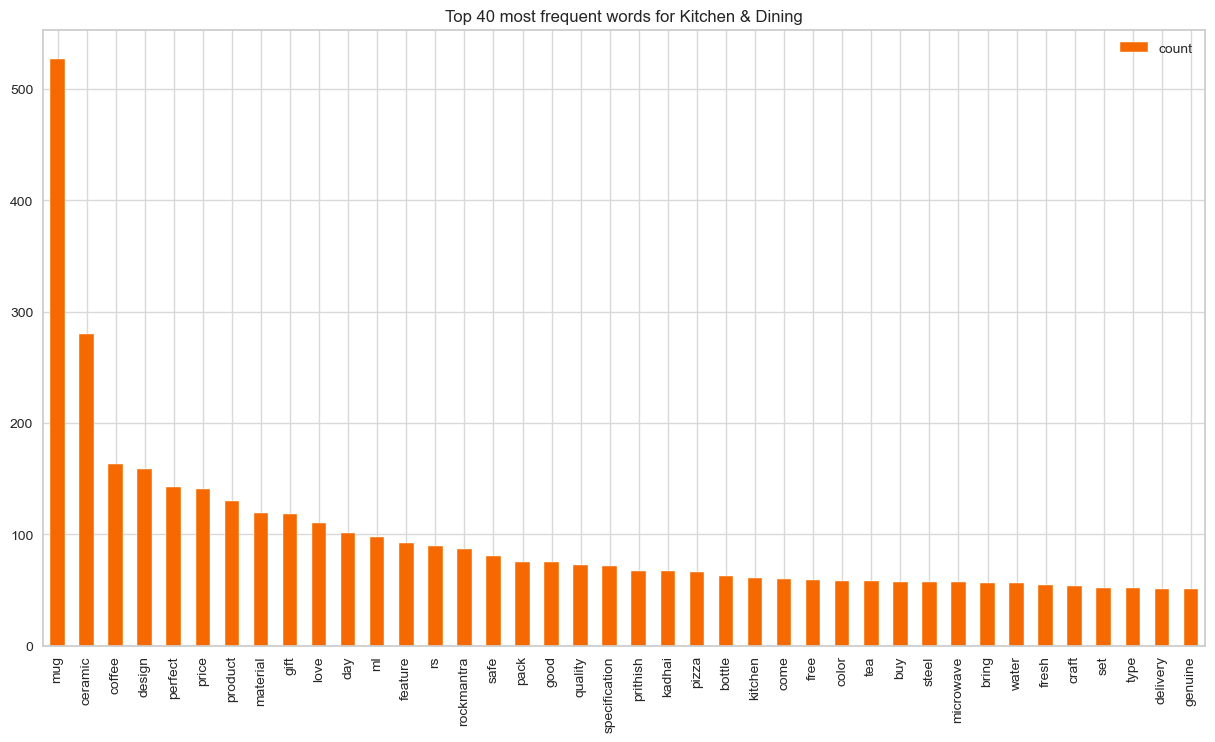

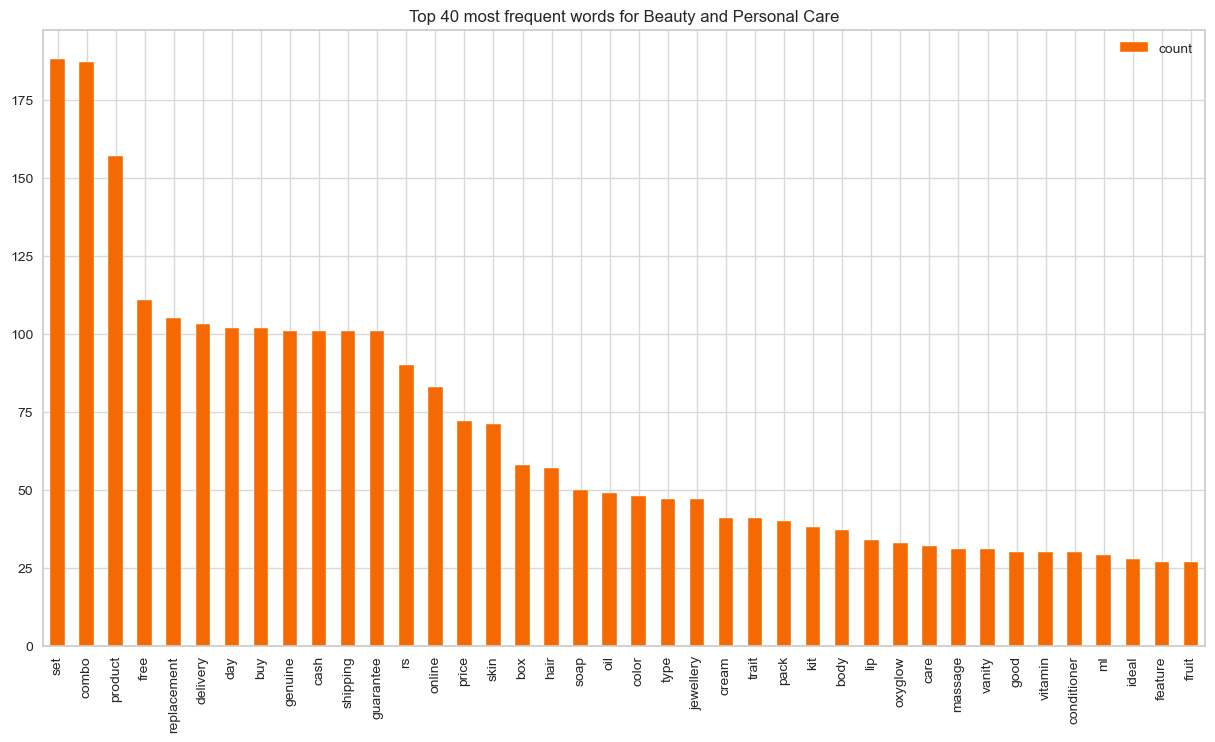

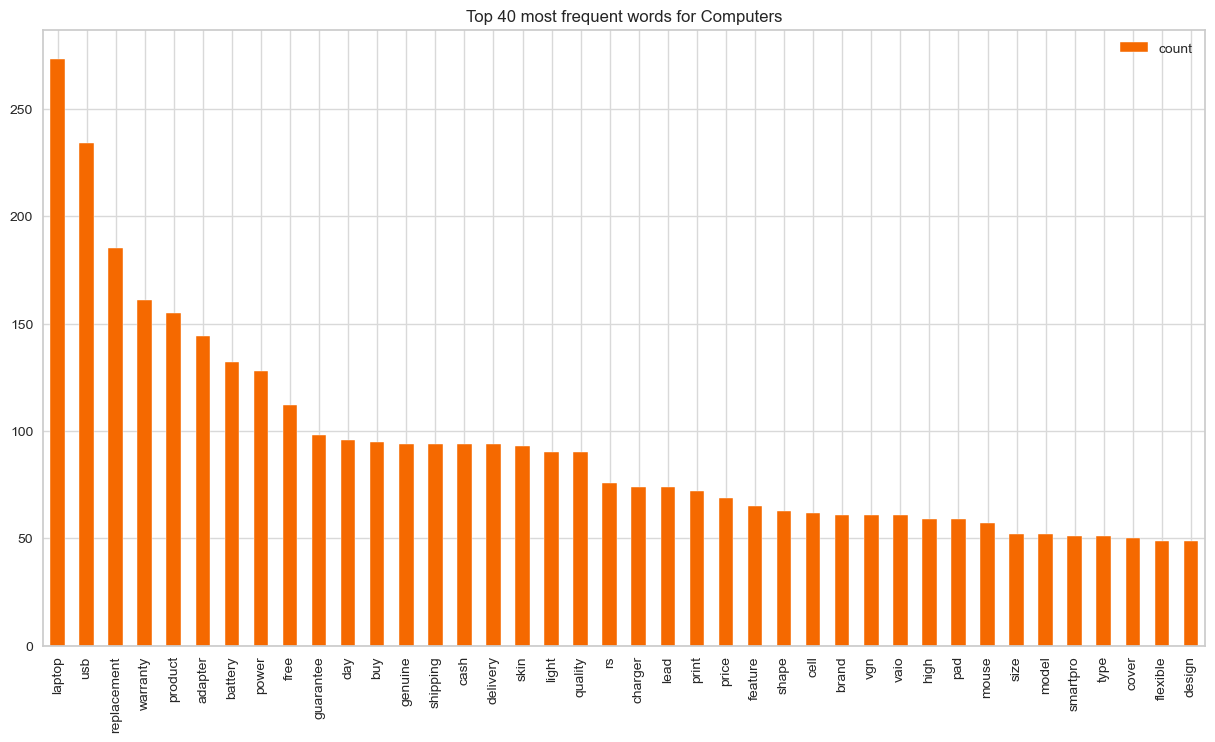

In [193]:
for category in categories:
    # get the top 40 most frequent words
    df_tokens = pd.DataFrame.from_dict(
        categories_desc_freqs[category], orient='index', columns=['count'])
    df_tokens = df_tokens.sort_values('count', ascending=False).head(40)
    
    df_tokens.plot(kind='bar', color="#f56900",
                   title=f'Top 40 most frequent words for {category}', figsize=(15, 8))

"Noise" words:

Measure: can refer to any product
- cm
- inch
- width
- height
- size

Positive adjectives: meant to promote a product but don't describe it
- genuine
- great
- perfect
- good
- ideal

Shipping: information not related to products
- shipping
- delivery

Monetary: not related to product description
- sale
- free
- price 
- rs
- buy
- discount
- cash

Packaging: describes the way the product is packaged
- package
- kit
- set
- pack

Product related: general words used to describe any product
- product
- feature
- quality
- specification
- type
- model
- color
- showpiece
- material

Warranty:
- replacement
- guarantee
- warranty

Other:
- online
- number
- general
- brand

In [194]:
noise_tokens = {
    'measure': ['inch', 'cm', 'width', 'height', 'size'],
    'pos_adjectives': ['genuine', 'great', 'perfect', 'good', 'ideal'],
    'shipping': ['shipping', 'delivery'],
    'monetary': ['sale', 'free', 'price', 'rs', 'buy', 'discount', 'cash'],
    'packaging': ['package', 'set', 'kit', 'pack'],
    'product': ['product', 'feature', 'quality', 'specification', 'type', 'model', 'color', 'showpiece', 'material'],
    'warranty': ['replacement', 'guarantee', 'warranty'],
    'other': ['online', 'number', 'general', 'brand']
}

In [195]:
df_category_frequency = pd.DataFrame(columns=['token', 'count', 'category'])

for category in categories:
    df_category = pd.DataFrame.from_dict(
        categories_desc_freqs[category], orient='index',
        columns=['count']).reset_index().rename(columns={'index': 'token'})
    df_category['category'] = category
    
    df_category_frequency = pd.concat([df_category_frequency, df_category], axis=0)
    
df_category_frequency    

token count         category
0      elegance     6  Home Furnishing
1     polyester    82  Home Furnishing
2    multicolor    75  Home Furnishing
3      abstract    68  Home Furnishing
4        eyelet    63  Home Furnishing
..          ...   ...              ...
964     peacock     5        Computers
965     feather     5        Computers
966  despicable     5        Computers
967     upwards     5        Computers
968        bull     5        Computers

[6833 rows x 3 columns]

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

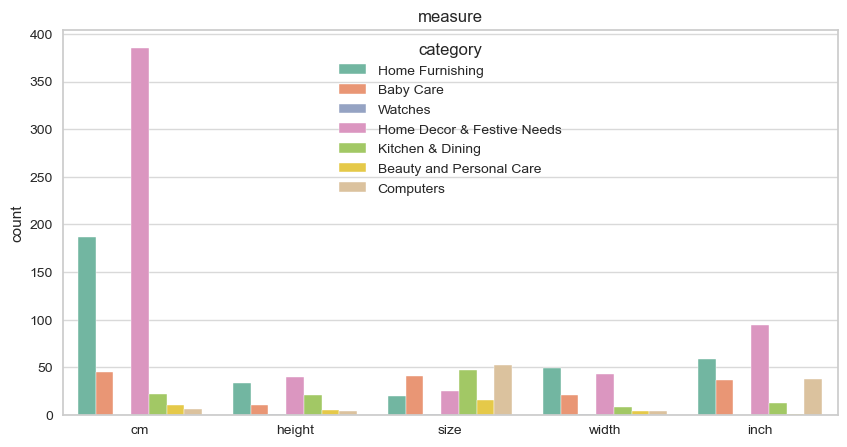

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

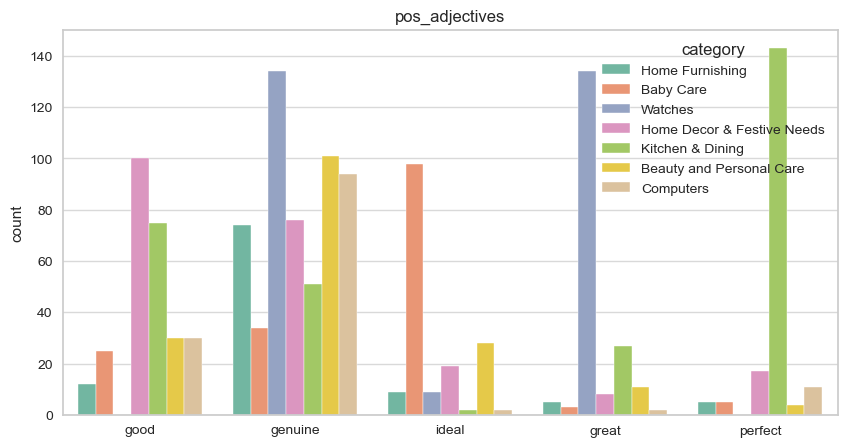

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

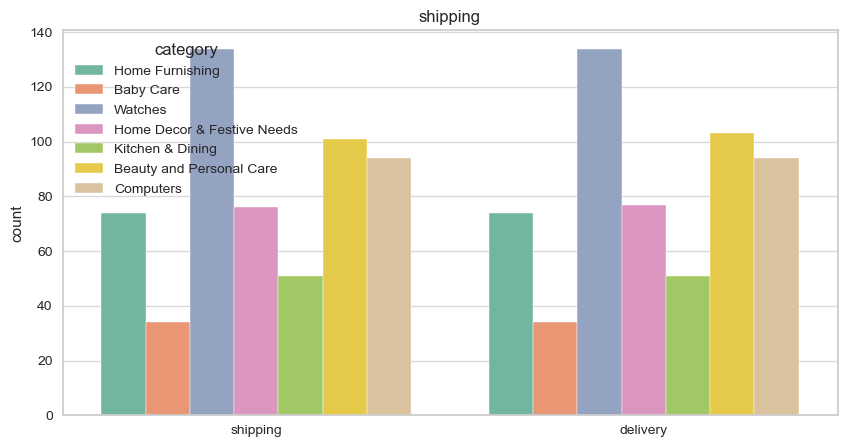

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

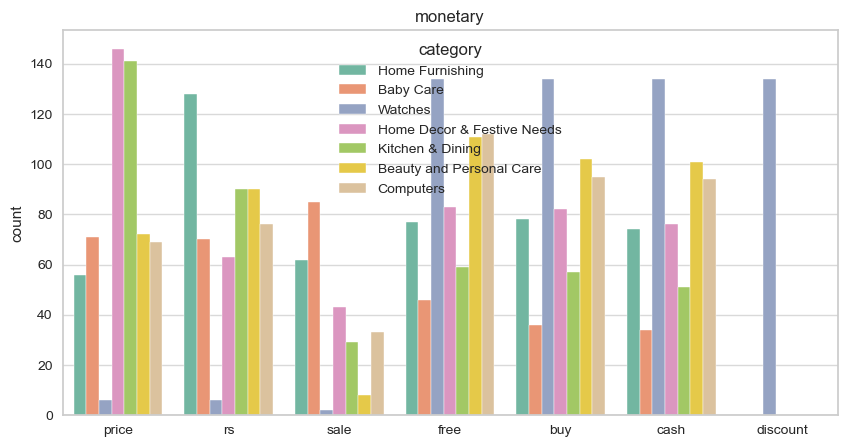

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

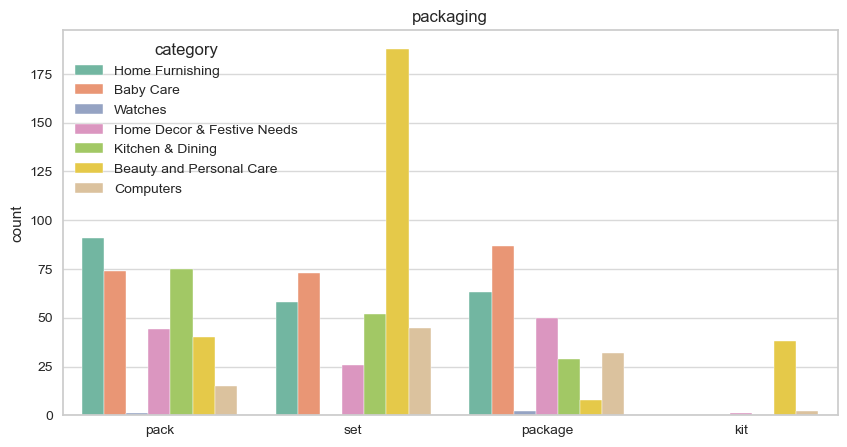

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

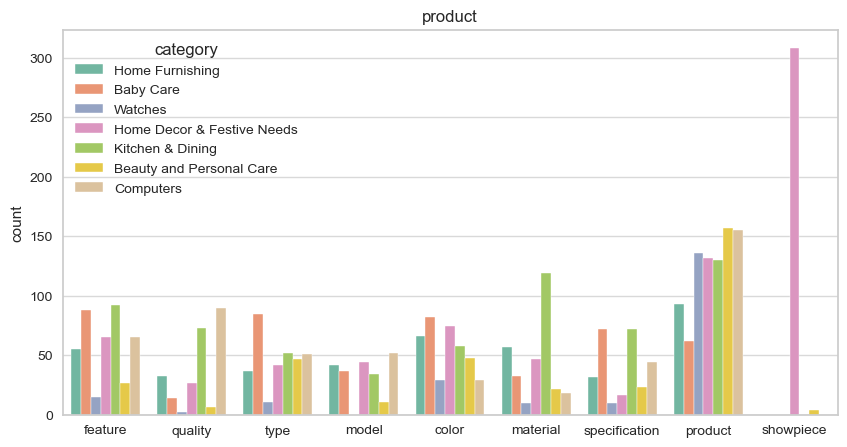

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

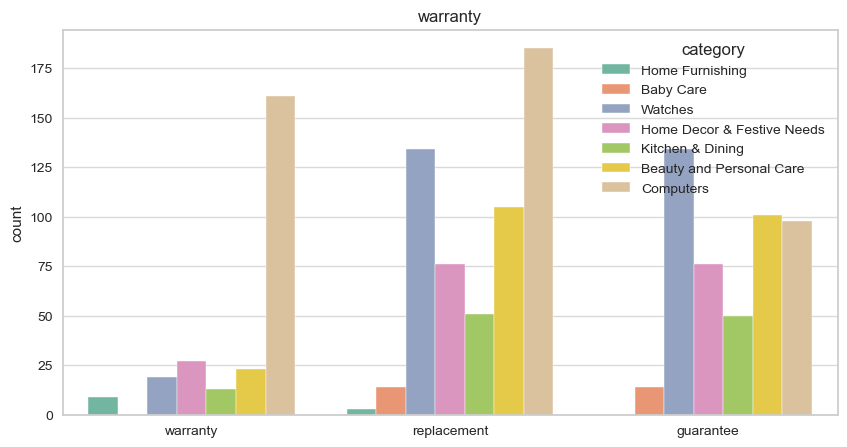

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

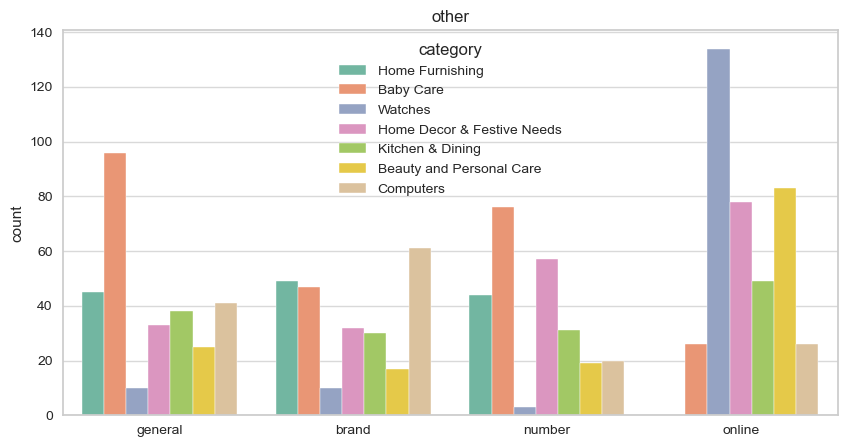

In [196]:
for noise_token in noise_tokens:
    noise_subset = df_category_frequency.loc[df_category_frequency['token'].isin(noise_tokens[noise_token]), :]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=noise_subset, x="token", y="count", hue="category")
    plt.title(noise_token)
    plt.xlabel(xlabel=None)
    plt.show()

In [61]:
noise_tokens_list = sum(noise_tokens.values(), [])
noise_tokens_list

['inch',
 'cm',
 'width',
 'height',
 'size',
 'genuine',
 'great',
 'perfect',
 'good',
 'ideal',
 'shipping',
 'delivery',
 'sale',
 'free',
 'price',
 'rs',
 'buy',
 'discount',
 'cash',
 'package',
 'set',
 'kit',
 'pack',
 'product',
 'feature',
 'quality',
 'specification',
 'type',
 'model',
 'color',
 'showpiece',
 'material',
 'replacement',
 'guarantee',
 'warranty',
 'online',
 'number',
 'general',
 'brand']

In [197]:
def remove_tokens(document, tokens_to_remove):
    """This function removes given token from a document
    
    Input: 
        document: string to process
        tokens_to_remove: array of tokens to remove
        
    Output:
        cleaned_document: processed string
        
    """
    
    # tokenize
    tokens = tokenize(document)
    
    # exclude stop words
    tokens = [token.text for token in tokens if not token.text in tokens_to_remove]
    
    return " ".join(tokens)

In [198]:
# Test function
random_desc = "perucci analog watch man perucci analog watch man buy perucci analog watch man online india great discount genuine product day replacement guarantee free shipping cash delivery"

remove_tokens(random_desc, noise_tokens_list)

'perucci analog watch man perucci analog watch man perucci analog watch man india day'

Apply to the dataframe

In [ ]:
df_to_process['description_processed_2'] = df_to_process['description_processed'].map(
    lambda x: remove_tokens(x, noise_tokens_list))

df_to_process

Difference between 1st and 2nd cleaning

In [200]:
get_text_len_difference(df_to_process['description_processed'], df_to_process['description_processed_2'])

'The original text was reduced by 24.94 % (from 385408 to 289280 chars)'

Difference between the raw description and the 2nd cleaning

In [201]:
get_text_len_difference(df_to_process['full_description'], df_to_process['description_processed_2'])

'The original text was reduced by 47.11 % (from 546968 to 289280 chars)'

**The least used words**

Rare words often have low information content, and they may not be representative of the text as a whole. Additionally, they can also lead to overfitting, as they can be specific to a small set of documents and not generalizable to the whole dataset.


Words that were used only 1 or 2 times:

In [202]:
df_token_corpus.loc[df_token_corpus['count'] < 3, :]

token  count
2341       close      2
2342    sunlight      2
2343    softness      2
2344     waranty      2
2345     returne      2
...          ...    ...
4091  negativity      1
4092        main      1
4093      rotate      1
4094   clockwise      1
4095   intention      1

[1755 rows x 2 columns]

We do have 1755 tokens that have been used only once or twice. We could replace rare words with a more general form and to have higher counts but it will represent a huge manual work, so at this stage we will simply remove them.

In [203]:
rare_tokens = df_token_corpus.loc[df_token_corpus['count'] < 3, 'token']
rare_tokens

2341         close
2342      sunlight
2343      softness
2344       waranty
2345       returne
           ...    
4091    negativity
4092          main
4093        rotate
4094     clockwise
4095     intention
Name: token, Length: 1755, dtype: object

In [ ]:
df_to_process['description_processed_3'] = df_to_process['description_processed_2'].map(
    lambda x: remove_tokens(x, list(rare_tokens)))

df_to_process

In [205]:
get_text_len_difference(df_to_process['full_description'], df_to_process['description_processed_3'])

'The original text was reduced by 50.85 % (from 546968 to 268859 chars)'

In [206]:
get_text_len_difference(df_to_process['description_processed_2'], df_to_process['description_processed_3'])

'The original text was reduced by 7.06 % (from 289280 to 268859 chars)'

# Feature extraction

Feature extraction is a fundamental step that involves converting text data into a format that can be easily processed by machine learning algorithms. There are various techniques available for feature extraction in NLP, like bag of words approaches and word embeddings.

## Bag of words
The bag-of-words method is commonly used for text classification purposes, where the vector of each word is used as a feature for training a classifier. Bag of words treats text as a collection of words without strict order, and ignores complicated semantic and syntactic information. We will explore 2 BoW methods:
1. CountVectorizer
2. TF-IDF

### CountVectorizer

CountVectorizer is used to convert a collection of text documents to a matrix of token counts, this implementation produces a sparse representation of the counts.

In [316]:
count_vectorizer = CountVectorizer()

start = time.time()

# apply the vectorizer to the corpus
X_cv = count_vectorizer.fit_transform(df_to_process['description_processed_3'])

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

X_cv.shape

execution time: 0.0283 seconds


(1050, 2304)

CountVectorizer produced a (1050, 2304) matrix, where each document is a row and each token is a column.

In [ ]:
print(len(count_vectorizer.vocabulary_))
count_vectorizer.vocabulary_

In [209]:
# display the document-term matrix as a dataframe to show the tokens
df_cv = pd.DataFrame(X_cv.todense(), columns=count_vectorizer.get_feature_names_out())
df_cv

aa  aapno  aari  ability  able  abode  absorbency  absorbent  abstract  \
0      0      0     0        0     0      0           0          0         5   
1      0      0     0        0     0      0           0          0         0   
2      0      0     0        0     0      0           1          0         0   
3      0      0     0        0     0      0           0          0         0   
4      0      0     0        0     0      0           0          0         0   
...   ..    ...   ...      ...   ...    ...         ...        ...       ...   
1045   0      0     0        0     0      0           0          0         0   
1046   0      0     0        0     0      0           0          0         0   
1047   0      0     0        0     0      0           0          0         0   
1048   0      0     0        0     0      0           0          0         0   
1049   0      0     0        0     0      0           0          0         0   

      ac  ...  york  young  youth  youthful  yuva  zero  zingalalaa  zone  \
0      0  ...     0      0      0         0     0     0           0     0   
1      0  ...     0      0      0         0     0     0           0     0   
2      0  ...     0      0      0         0     0     0           0     0   
3      0  ...     0      0      0         0     0     0           0     0   
4      0  ...     0      0      0         0     0     0           0     0   
...   ..  ...   ...    ...    ...       ...   ...   ...         ...   ...   
1045   0  ...     0      0      0         0     0     0           0     0   
1046   0  ...     0      0      0         0     0     0           0     0   
1047   0  ...     0      0      0         0     0     0           0     0   
1048   0  ...     0      0      0         0     0     0           0     0   
1049   0  ...     0      0      0         0     0     0           0     0   

      zora  zyxel  
0        0      0  
1        0      0  
2        0      0  
3        0      0  
4        0      0  
...    ...    ...  
1045     0      0  
1046     0      0  
1047     0      0  
1048     0      0  
1049     0      0  

[1050 rows x 2304 columns]

#### Dimensionality reduction

Our vocabulary, which is a collection of all unique tokens in a corpus, has the size of 2304 tokens. Even after applying text preprocessing techniques, lemmatizing, removing specific words, ponctuation marks, etc, that helped to reduce a lot the size of the vocabulary, we still get a very large dimension matrix. Using such a matrix to train a classification model will lead to long training times and intense memory consumption. Therefore, reducing its size is essential to avoid performing expensvie calculations.

We will use both PCA and T-SNE methods.

**PCA**


The goal of PCA is to reduce the number of variables of a data set, while preserving as much information as possible. It does this by transforming the original variables into a set of new, uncorrelated variables. We will set the `n_components` parameter to 0.99 so that PCA selects the number of components that explain 99% of variance.

In [216]:
feat_pca_cv = utils.get_pca_reduced_data(df_cv, n_components=0.99)

Dimensions before PCA :  (1050, 2304)
Dimensions after PCA :  (1050, 603)


We were able to reduce 2304 dimensions to 603.

**T-SNE**


T-SNE (t-distributed Stochastic Neighbor Embedding) is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. We will use it to represent our data in 2 dimensions.

In [217]:
df_tsne_cv = utils.get_tsne_reduced_dataframe(feat_pca_cv)
df_tsne_cv.shape

(1050, 2)

Display the features on the graph with the categories

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

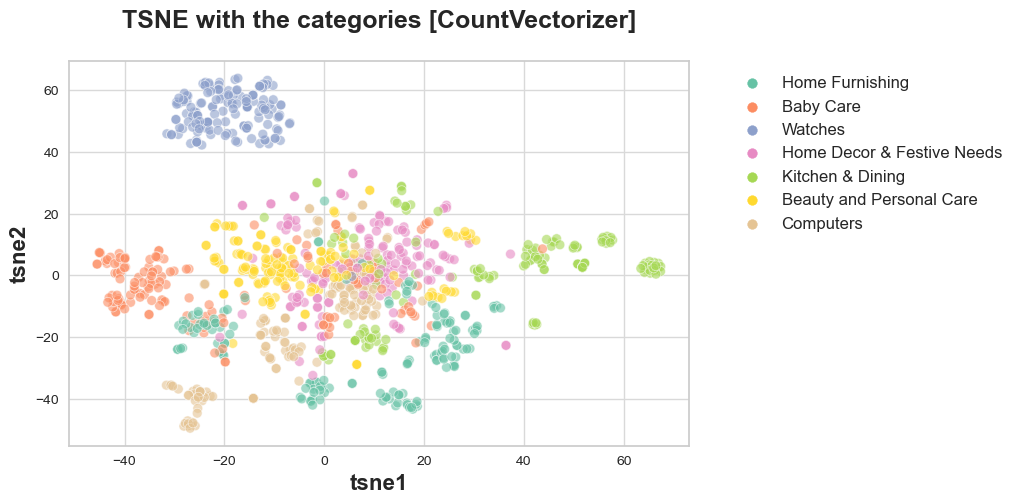

In [227]:
utils.display_tsne_categories(df_tsne_cv, df_to_process['category_0'], 'CountVectorizer')

We observe that some categories are visually well separated, especially such Watches and Baby Care, others seem to be mixed up.

#### Clustering

We will confirm the graphic analysis by doing a clustering.

The goal is to perform a K-Means clustering with n_clusters = 7 to see how the categories are assigned

Encode category

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df_to_process['category_0_label'] = label_encoder.fit_transform(df_to_process['category_0'])
df_to_process

ARI :  0.3946


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

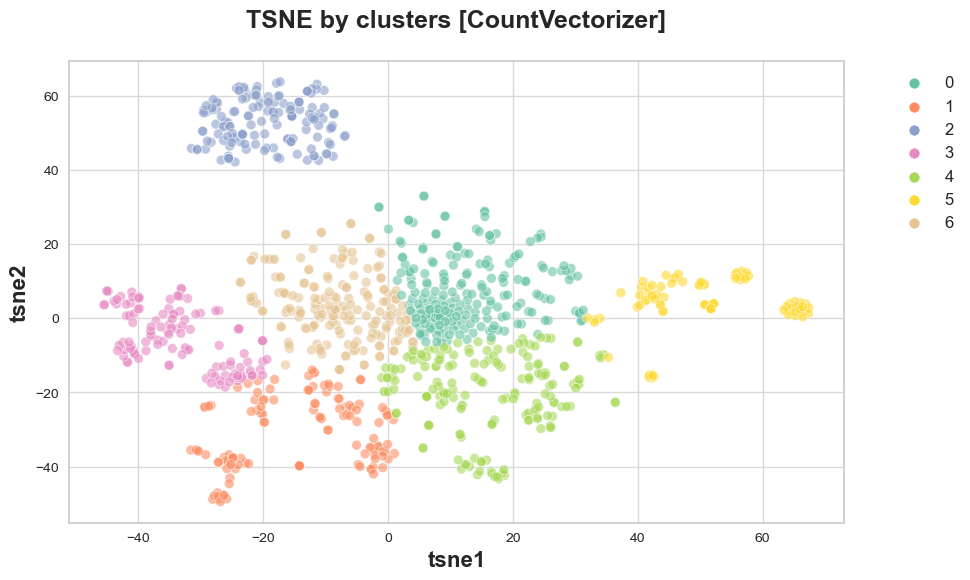

In [228]:
utils.perform_clustering(df_tsne_cv, true_labels = df_to_process["category_0_label"], method_name='CountVectorizer')

The ARI score is quite low (0.39), however the clusters are well separated on the graph.

It would be interesting to compare the inertia and silhouette scores for different number of clusters to see if 7 is the best fit.

cluster 2: 0.48304465413093567 score
cluster 3: 0.42216387391090393 score
cluster 4: 0.4093252122402191 score
cluster 5: 0.44501993060112 score
cluster 6: 0.4444272518157959 score
cluster 7: 0.4332914352416992 score
cluster 8: 0.4398338794708252 score
cluster 9: 0.45166754722595215 score
cluster 10: 0.47119924426078796 score


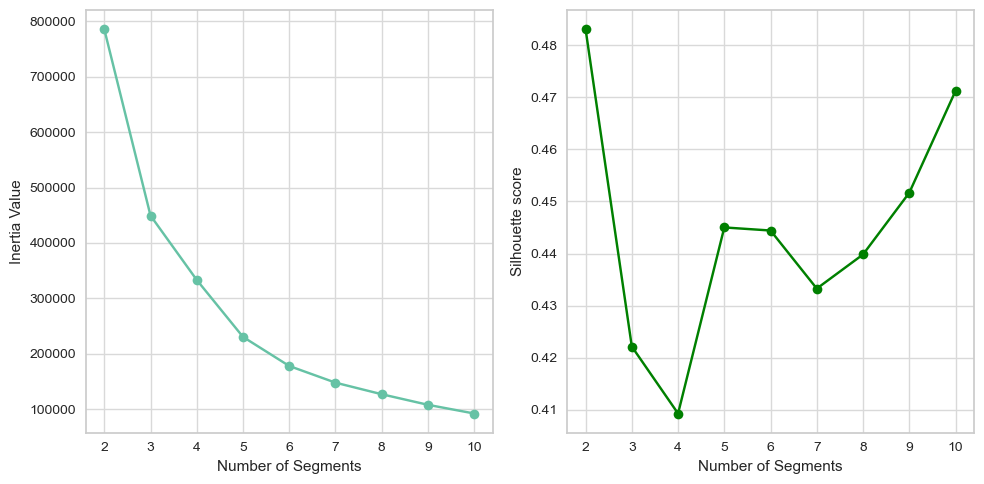

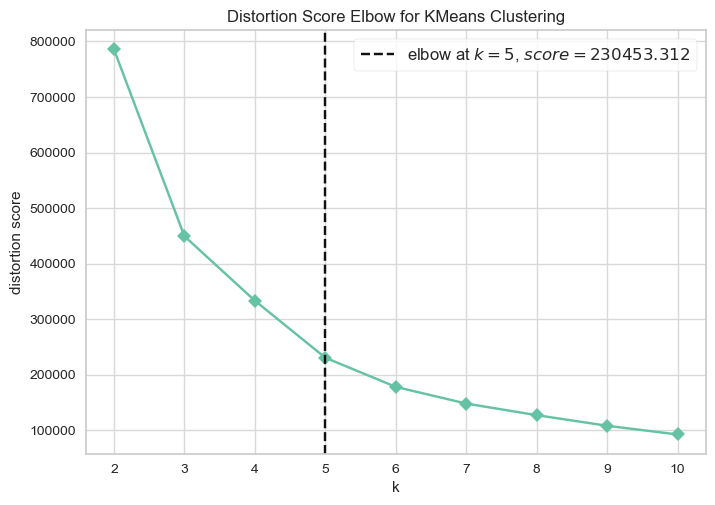

In [233]:
utils.get_cluster_scores(df_tsne_cv)

The distortion score indicates 5 as the best number of clusters, and the silhouette score is also higher for 5 than for 7 clusters. 

To conclude, the CountVectorizer method might not be the most efficient for our use case.

### TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical measure that reflects the importance of a word in a document or corpus. It is calculated as the product of the term frequency (number of times a word appears in a document) and the inverse document frequency (logarithm of the total number of documents divided by the number of documents containing the word). The resulting TF-IDF vectors represent each document as a vector in a high-dimensional space where tokens that are more important in the document have higher weights.

We will proceed with exactly the same methodology as we did for the CountVectorizer:

- calculating the document vectors
- dimensiality reduction with PCA and T-SNE
- clustering with KMeans

In [317]:
tfidf_vectorizer = TfidfVectorizer()

start = time.time()

# apply the vectorizer to the corpus
X_tfidf = tfidf_vectorizer.fit_transform(df_to_process['description_processed_3'])

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

# display the document-term matrix
df_tfidf = pd.DataFrame(X_tfidf.todense(), columns=tfidf_vectorizer.get_feature_names_out())
df_tfidf

execution time: 0.0298 seconds


aa  aapno   aari  ability   able  abode  absorbency  absorbent  \
0    0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   
1    0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   
2    0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0659     0.0000   
3    0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   
4    0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   
...     ...    ...    ...      ...    ...    ...         ...        ...   
1045 0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   
1046 0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   
1047 0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   
1048 0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   
1049 0.0000 0.0000 0.0000   0.0000 0.0000 0.0000      0.0000     0.0000   

      abstract     ac  ...   york  young  youth  youthful   yuva   zero  \
0       0.2051 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
1       0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
2       0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
3       0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
4       0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
...        ...    ...  ...    ...    ...    ...       ...    ...    ...   
1045    0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
1046    0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
1047    0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
1048    0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   
1049    0.0000 0.0000  ... 0.0000 0.0000 0.0000    0.0000 0.0000 0.0000   

      zingalalaa   zone   zora  zyxel  
0         0.0000 0.0000 0.0000 0.0000  
1         0.0000 0.0000 0.0000 0.0000  
2         0.0000 0.0000 0.0000 0.0000  
3         0.0000 0.0000 0.0000 0.0000  
4         0.0000 0.0000 0.0000 0.0000  
...          ...    ...    ...    ...  
1045      0.0000 0.0000 0.0000 0.0000  
1046      0.0000 0.0000 0.0000 0.0000  
1047      0.0000 0.0000 0.0000 0.0000  
1048      0.0000 0.0000 0.0000 0.0000  
1049      0.0000 0.0000 0.0000 0.0000  

[1050 rows x 2304 columns]

#### Dimensionality reduction

**PCA**

In [234]:
feat_pca_tfidf = utils.get_pca_reduced_data(df_tfidf, n_components=0.99)

Dimensions before PCA :  (1050, 2304)
Dimensions after PCA :  (1050, 733)


**T-SNE**

In [235]:
df_tsne_tfidf = utils.get_tsne_reduced_dataframe(feat_pca_tfidf)
df_tsne_tfidf.shape

(1050, 2)

Display the features with the categories

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

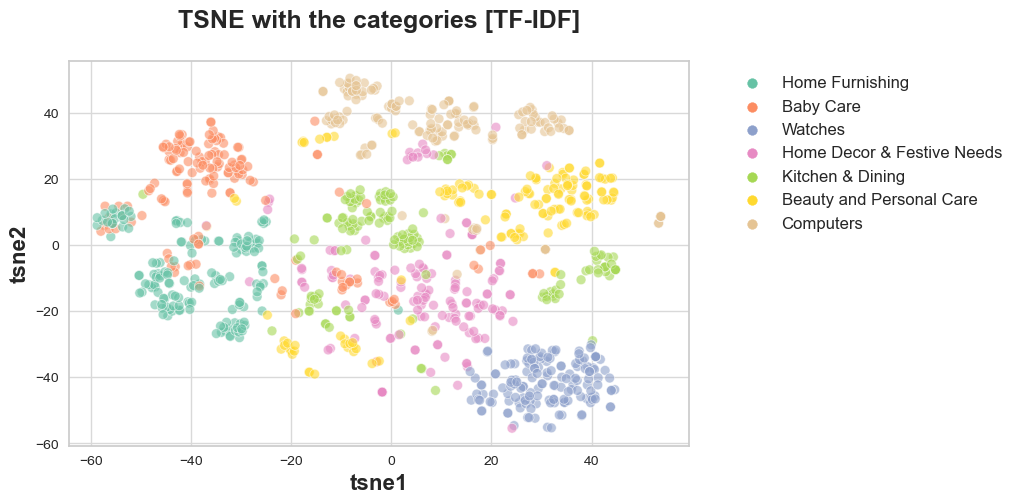

In [236]:
utils.display_tsne_categories(df_tsne_tfidf, df_to_process['category_0'], 'TF-IDF')

From the graph above we can observe that different categories are better separated than with CountVectorizer, some categories like 'Watches' (in blue), 'Home Furnishing' (in turquoise), 'Computers' (in beige) are clearly disctinctive from the other categories. We still see however other groups mixed up.

#### Clustering

ARI :  0.5128


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

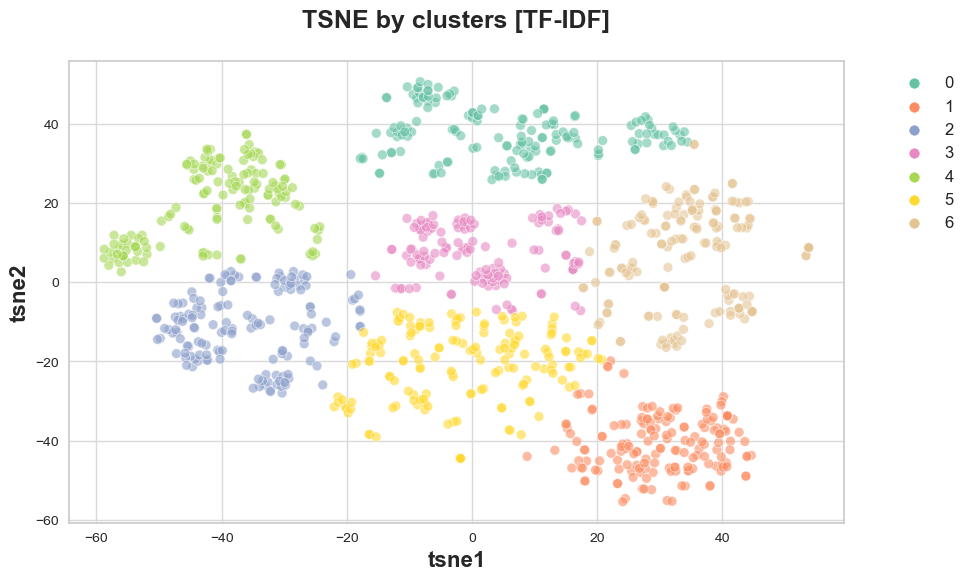

In [237]:
utils.perform_clustering(df_tsne_tfidf, true_labels = df_to_process["category_0_label"], method_name='TF-IDF')

The ARI score for the TF-IDF is higher than with the CountVectorizer (0.51), visually the clusters are well separated, it confirms our previous assumption from the previous graph.

Let's check if TF-IDF method considers 7 clusters as the best fit:

cluster 2: 0.3856850564479828 score
cluster 3: 0.44267362356185913 score
cluster 4: 0.41392675042152405 score
cluster 5: 0.4329695701599121 score
cluster 6: 0.4387705326080322 score
cluster 7: 0.45060911774635315 score
cluster 8: 0.45230451226234436 score
cluster 9: 0.4446377754211426 score
cluster 10: 0.44553613662719727 score


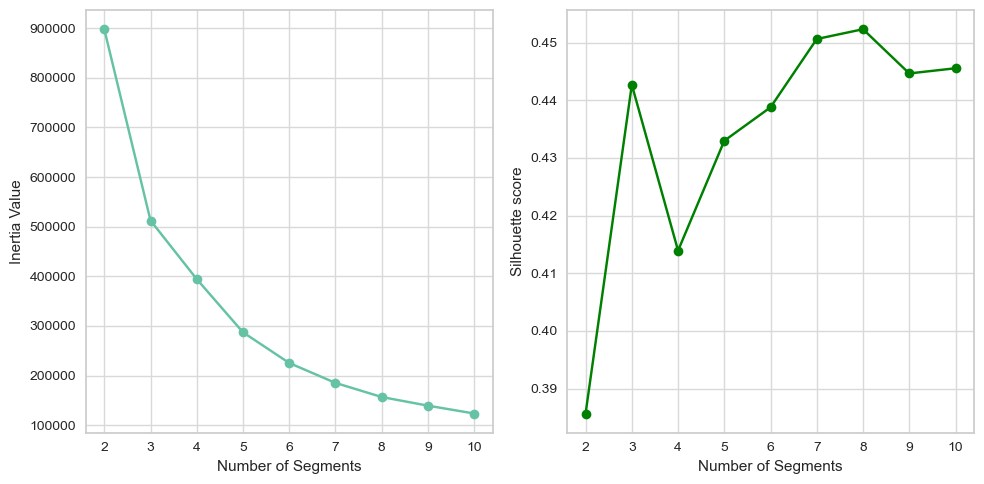

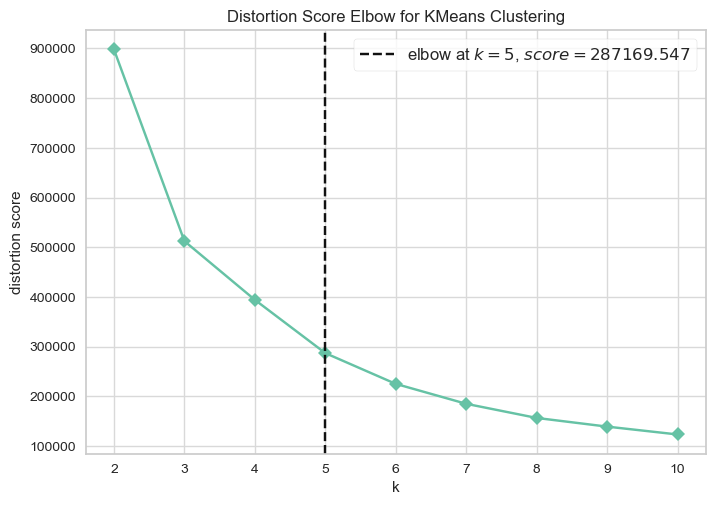

In [238]:
utils.get_cluster_scores(df_tsne_tfidf)

We can notice that 5 has the best distorsion score as for the CountVectorizer. The silhouette score is higher for 7 clusters and is best for 8, so it is pretty close to our true dataset categorization.

## Word Embedding

Even if the bag-of-words approach is a simple and efficient method, it has some disadvantages:

- Context and meaning are lost.
- The document-term matrix is large and sparse.
- Vectorization is relative to the corpus (similar words will have different vectors on another corpus).

Let's explore other vectorization methods as text embeddings that will overcome these shortcomings.

### Word2Vec

**Word2Vec** is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. **Word2Vec** itself is not a deep neural network, but it turns input text into a numerical form that deep neural networks can process as inputs.


The first step is to transform the text data into a list of documents containing a list of tokens.

We will use the Word2Vec model from the `gensim` library as well as the preprocessing function (`simple_preprocess`) that comes with it.

In [ ]:
documents = df_to_process['description_processed_3'].to_list()
documents = [simple_preprocess(document) for document in documents]
print(len(documents))
documents[:5]

Word2Vec will retrieve all unique words from all sub-lists of documents and construct the vocabulary.

Parameters:

- vector_size: The size means the dimensionality of word vectors

- window: The maximum distance between the target word and its neighboring word.

- min_count: Ignores all words with total frequency lower than this, we have already removed words with the frequency lower than 3.

- sg: Selects training algorithm: 1 for Skip-Gram; 0 for CBOW (Continuous Bag of Words), we will use Skip-Gram as it is more accurate.

- workers: The number of worker threads used to train the model.

In [342]:
start = time.time()

print('Initializing the Word2Vec model...')
w2v_model = Word2Vec(vector_size=300, window=5, min_count=2, sg=1, seed=42, workers=5)

print('Preparing the model vocabulary...')
w2v_model.build_vocab(documents) 

print('Training the model...')
w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=100)

word_vectors = w2v_model.wv

w2v_words = word_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

Initializing the Word2Vec model...
Preparing the model vocabulary...
Training the model...
Vocabulary size: 2300
Word2Vec trained
execution time: 7.2183 seconds


In [343]:
word_vectors

In [344]:
vector = word_vectors["watch"]  # numpy vector of a word
vector

array([-0.07721682,  0.2501775 , -0.46905118, -0.14549479,  0.4943908 ,
       -0.16974309, -0.12848318, -0.04982677,  0.3210377 ,  0.092527  ,
       -0.3088267 , -0.09568941,  0.35644317,  0.02060828, -0.36792174,
        0.5710311 , -0.37143403, -0.32793272, -0.36324626, -0.14948793,
        0.5057009 , -0.65971136, -0.30545473, -0.5758821 ,  0.213821  ,
       -0.5904002 , -0.2447352 , -0.21982908,  0.19758841,  0.1829799 ,
        0.1880223 ,  0.00318304,  0.552251  , -0.0142154 , -0.1794062 ,
       -0.2627938 , -0.34512103, -0.07571466,  0.21397272,  0.41730455,
        0.2366715 ,  0.01864351,  0.31639922,  0.06521311,  0.32288647,
       -0.06789353, -0.06628775,  0.08113109,  0.12746303,  0.14142898,
       -0.0220169 ,  0.4459152 , -0.35922185,  0.18645559,  0.3254491 ,
        0.2696217 ,  0.05113851, -0.03668879, -0.1962891 ,  0.39193743,
       -0.2366241 ,  0.19770443, -0.3038417 , -0.03651577,  0.30309135,
        0.3859023 , -0.02836924, -0.00647745,  0.64382964, -0.07

In [345]:
word_vectors.most_similar(positive="watch", topn=5)

[('analog', 0.6751606464385986),
 ('petrol', 0.5693447589874268),
 ('lois', 0.5688977837562561),
 ('elantra', 0.5665733218193054),
 ('titan', 0.562649667263031)]

In [264]:
word_vectors.most_similar(positive="pillow", topn=5)

[('bedsheet', 0.6709272861480713),
 ('mahadev', 0.6090927124023438),
 ('jbc', 0.5893954634666443),
 ('bela', 0.5707508325576782),
 ('filling', 0.5482594966888428)]

Prepare the embedding model by using tensofrlow Tokenizer tool and pad the sequences.

Since the input data for a deep learning model must be a single tensor, samples that are shorter than the longest item need to be padded with some placeholder value. If `maxlen` parameter is not provided, sequences will be padded to the length of the longest individual sequence.

In [346]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(documents)

# pad sequences to the same length (to the longest sentence)
X_sequences = pad_sequences(tokenizer.texts_to_sequences(documents), padding='post') 
                                                   
print(X_sequences.shape)
sequence_length = X_sequences.shape[1]
print(sequence_length)
X_sequences

(1050, 253)
253


array([[ 641,   74,   24, ...,    0,    0,    0],
       [1482,    7,   97, ...,    0,    0,    0],
       [1112,    7,  672, ...,    0,    0,    0],
       ...,
       [1304,  603,  341, ...,    0,    0,    0],
       [ 382,  258,  199, ...,    0,    0,    0],
       [1304,  341,  199, ...,    0,    0,    0]], dtype=int32)

In [347]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print("Number of unique words: %i" % vocab_size)

Number of unique words: 2303


**Create embedding matrix**

In [348]:
embedding_matrix = np.zeros((vocab_size, 300))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = word_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = word_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Word embedding rate :  0.9991
Embedding matrix: (2303, 300)


In [349]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11909038,  0.0167525 ,  0.3608411 , ..., -0.25261447,
        -0.47388503,  0.45511204],
       [ 0.15342544, -0.21196277, -0.37144405, ..., -0.37505639,
        -0.14491902,  0.28968972],
       ...,
       [ 0.14419833,  0.00279754,  0.18714496, ...,  0.18496354,
        -0.023474  ,  0.13487822],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

**Create embedding model**

The **Embedding** layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).


The **GlobalAveragePooling1D** layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

In [355]:
# init the Input layer
word_input = Input(shape=(sequence_length,), dtype='float64')

# init the Embedding layer
word_embedding = Embedding(input_dim=vocab_size,
                         output_dim=300,
                         weights = [embedding_matrix],
                         input_length=sequence_length)(word_input)

word_vec = GlobalAveragePooling1D()(word_embedding) 

# init the Model
embedding_model = Model([word_input], word_vec, name='embedding_model')

embedding_model.summary()

Model: "embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 253)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 253, 300)          690900    
                                                                 
 global_average_pooling1d_9  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 690900 (2.64 MB)
Trainable params: 690900 (2.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Execute the model**

In [389]:
start = time.time()

embeddings = embedding_model.predict(X_sequences)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

embeddings.shape

33/33 [==============================] - 0s 1ms/step
execution time: 0.076 seconds


(1050, 300)

In [357]:
embeddings.shape

(1050, 300)

**T-SNE**

In [279]:
df_tsne_w2v = utils.get_tsne_reduced_dataframe(embeddings)
df_tsne_w2v.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

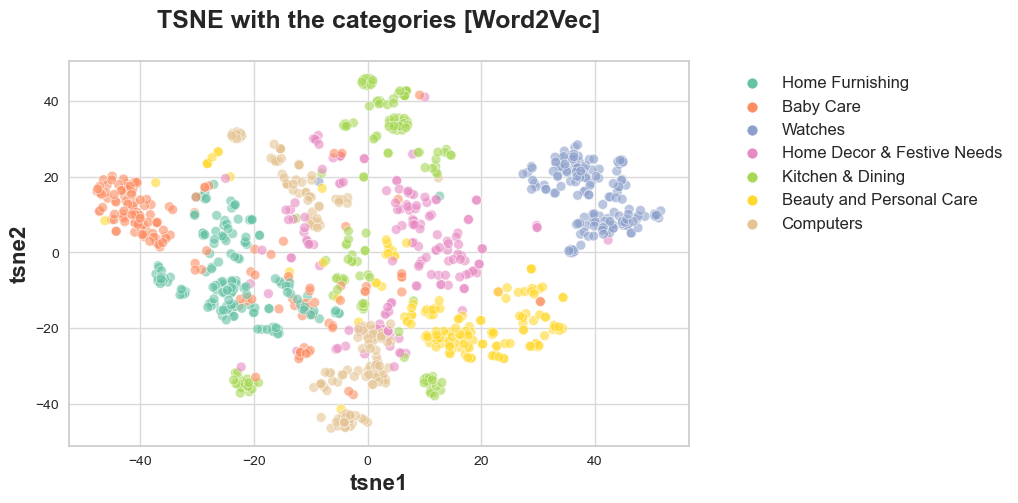

In [280]:
utils.display_tsne_categories(df_tsne_w2v, df_to_process['category_0'], 'Word2Vec')

The separation of certain categories is clearly visible ('Watches', 'Baby care', 'Beauty and Personal Care'), but the model has some difficulties to distinguish the other classes.

**Clustering**

ARI :  0.4546


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

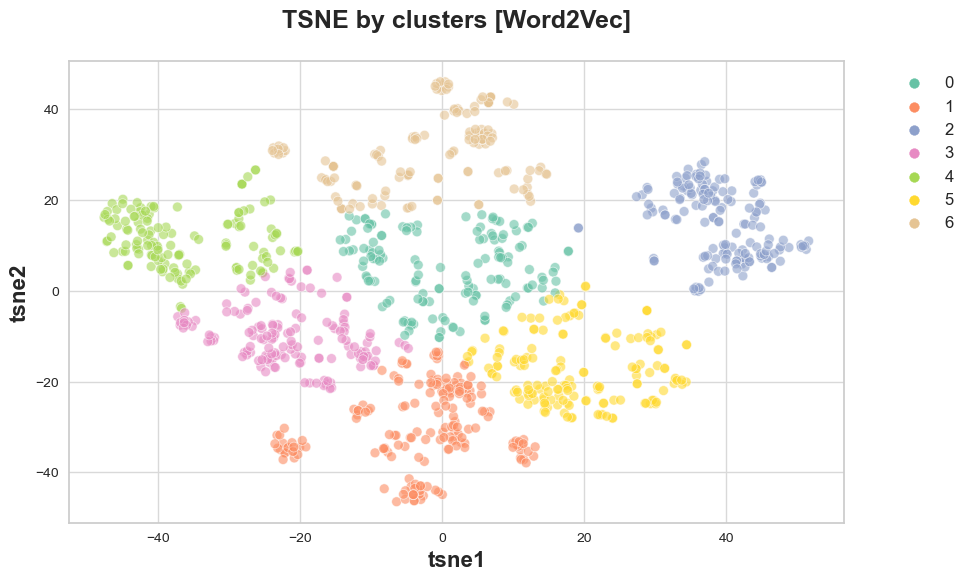

In [281]:
utils.perform_clustering(df_tsne_w2v, true_labels = df_to_process["category_0_label"], method_name='Word2Vec')

The ARI score of 0.45 is in between the CountVectorizer and TF-IDF bag of words methods.

cluster 2: 0.36653679609298706 score
cluster 3: 0.4310965836048126 score
cluster 4: 0.44995740056037903 score
cluster 5: 0.42253026366233826 score
cluster 6: 0.43623998761177063 score
cluster 7: 0.4391278326511383 score
cluster 8: 0.45240750908851624 score
cluster 9: 0.4537726044654846 score
cluster 10: 0.45854511857032776 score


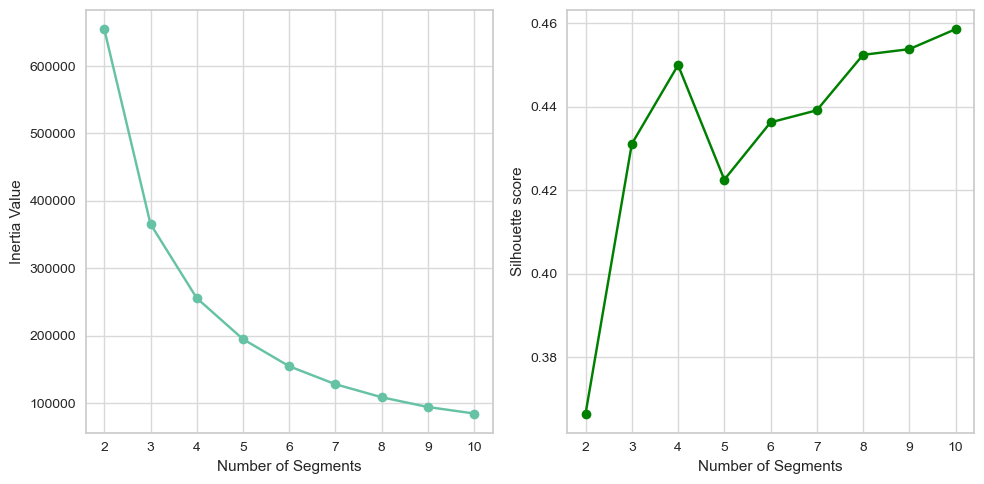

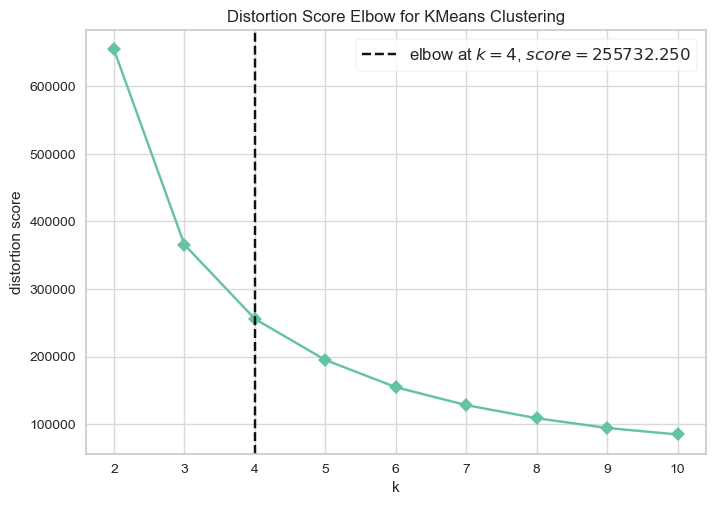

In [282]:
utils.get_cluster_scores(df_tsne_w2v)

 Separation in 4 clusters has a better distortion and silhouette scores than for 7.

### Bert

**Word2Vec** model generates a single "word embedding" representation for each word in the vocabulary, so 'bank' would have the same representation in 'bank deposit' and 'river bank'. Contextual models like **BERT** on the other hand generate a representation of each word that is based on the other words in the sentence.


**BERT**, or *Bidirectional Encoder Representations from Transformers*, is a method of pre-training language representations which obtains state-of-the-art results on a wide array of Natural Language Processing (NLP) tasks.  It will train a general-purpose "language understanding" model on a large text corpus (like Wikipedia), which then be used on the NLP tasks (like question answering). BERT outperforms previous methods because it is the first unsupervised, deeply bidirectional system for pre-training NLP.


We will use the model and tokenizer from HuggingFace.

First, start by tokenizing the documents. A tokenizer is in charge of preparing the inputs for a model.

In [106]:
BERT_MODEL = 'bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

We need to define the padding so that each tokenized sentence will have the same length, and the truncation so if the sentence is too long it will be cut off.

We will use raw non-preprocessed text for the models based on Transformers, for example, we should not do:

1. Stemming or lemmatization : Bert uses BPE (Byte- Pair Encoding to shrink its vocab size), so words like run and running will ultimately be decoded to run + ##ing. So it's better not to convert running into run because, in some NLP problems, you need that information.

2. De-Capitalization - Bert provides cased and uncased models, we'll use the uncased model that will not change related to the capitalization of the text (it does not make a difference between english and English).

3. Removing high-frequency words - Bert uses the Transformer model, which works on the attention principal. So when you finetune, so it will look only on those words which will impact the output and not on words which are common in all documents.

4. Removing stop-words and punctuation: BERT learns to compute text representations in context, that also comprises stopwords and punctuation which can very much change the meaning of a sentence. Therefore, removing stopwords and punctuation would just imply removing context which BERT could have used to get better results.

In [283]:
bert_tokenized = bert_tokenizer(df_to_process['full_description'].to_list(),
                                padding='max_length',
                                truncation=True,
                                return_attention_mask=True,
                                return_token_type_ids=True,
                                return_tensors='tf')

bert_tokenized

{'input_ids': <tf.Tensor: shape=(1050, 512), dtype=int32, numpy=
array([[  101, 27745, 26572, ...,     0,     0,     0],
       [  101,  2938,  4048, ...,     0,     0,     0],
       [  101, 19329,  4502, ...,     0,     0,     0],
       ...,
       [  101, 19169,  2135, ...,     0,     0,     0],
       [  101,  2813,  2386, ...,     0,     0,     0],
       [  101, 19169,  2135, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1050, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1050, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

The result of tokenizing is a dictionary that contains:

- `input_ids`: that are the tokens expressed in numbers
- `token_type_ids`: a list of 0s and 1s that says which token belongs to which input sentence
- `attention_mask`: binary tensor indicating the position of the padded indices so that the model does not attend to them

In [284]:
print(bert_tokenized['input_ids'].shape)
print(bert_tokenized['token_type_ids'].shape)
print(bert_tokenized['attention_mask'].shape)

(1050, 512)
(1050, 512)
(1050, 512)


Define the model.

In [335]:
bert_model = TFAutoModel.from_pretrained(BERT_MODEL)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

We will use `.predict()` method and not `__call__` because it loops over the data in batches and can scale to a large quantity of data. The default value for the batch_size is 32

In [336]:
start = time.time()

outputs = bert_model.predict(
    [bert_tokenized['input_ids'], bert_tokenized['attention_mask'],
        bert_tokenized['token_type_ids']],
    batch_size=32)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

33/33 [==============================] - 232s 7s/step
execution time: 233.0984 seconds


In [ ]:
outputs

We are only interested in the hidden state associated with the initial token [CLS], which somehow captures the semantics of the entire sentence better than the others.

In [288]:
features_bert = np.array(outputs['last_hidden_state'])
features_bert.shape

(1050, 512, 768)

In [289]:
features_bert = features_bert.mean(axis=1)
features_bert.shape

(1050, 768)

**PCA**

In [293]:
feat_pca_bert = utils.get_pca_reduced_data(features_bert, n_components=0.99)

Dimensions before PCA :  (1050, 768)
Dimensions after PCA :  (1050, 278)


**T-SNE**

In [294]:
df_tsne_bert = get_tsne_reduced_dataframe(feat_pca_bert)
df_tsne_bert.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

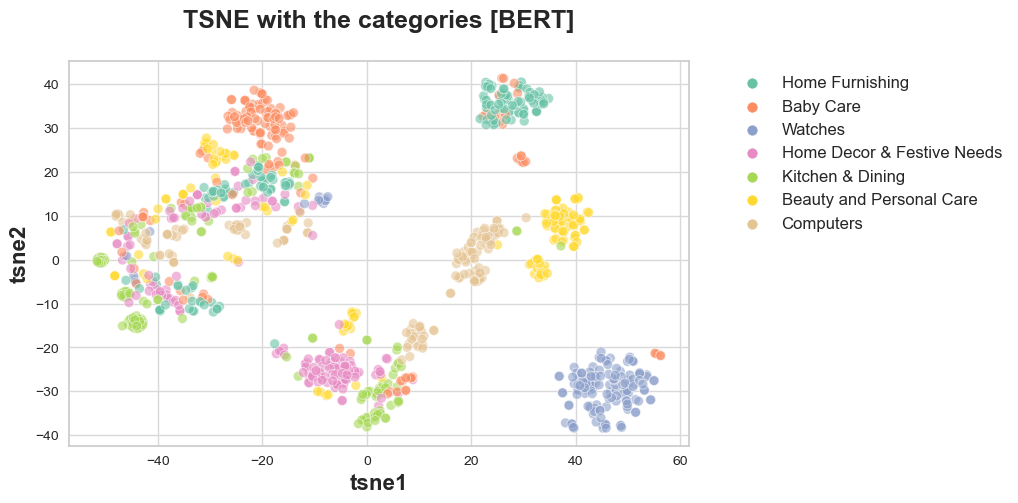

In [295]:
utils.display_tsne_categories(df_tsne_bert, df_to_process['category_0'], 'BERT')

We can notice from the graph that even some of the categories seem to be well defined ('Watches', 'Home Furnishing', 'Baby care' for instance), there is some confusion as to the other classes, and some of the categories get totally mixed up.

**Clustering**

ARI :  0.3058


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

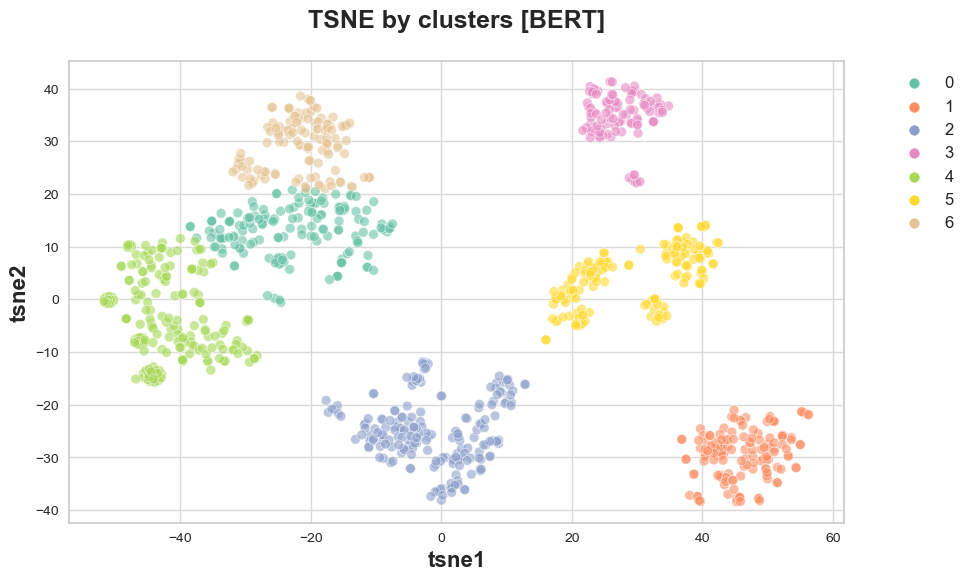

In [296]:
utils.perform_clustering(df_tsne_bert, true_labels = df_to_process["category_0_label"], method_name='BERT')

The ARI score confirmed our assumption, for the moment it is the lowest that we could obtain from all the other methods.
A possible explanation might be however is that the product descriptions are not real life sentences/phrases and BERT might have trouble distinguishing language patterns from this kind of textual data.

**Using Roberta model**

Just for curiosity, let's try another model like Roberta to see if we obtain better results. Roberta stands for 'A Robustly Optimized BERT Pretraining Approach', it builds on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

The Roberta model is case sensitive, so we'll transform description to lowercase.

In [298]:
df_to_process['description_lowercase'] = df_to_process['full_description'].map(lambda x: x.lower())
df_to_process[['full_description', 'description_lowercase']]

full_description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [299]:
ROBERTA_MODEL = 'roberta-base'
roberta_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_MODEL)

In [300]:
roberta_tokenized = roberta_tokenizer(df_to_process['description_lowercase'].to_list(),
                                padding='max_length',
                                truncation=True,
                                return_attention_mask=True,
                                return_token_type_ids=True,
                                return_tensors='tf')

roberta_tokenized

{'input_ids': <tf.Tensor: shape=(1050, 512), dtype=int32, numpy=
array([[    0,   242,  4308, ...,     1,     1,     1],
       [    0,    29,  2681, ...,     1,     1,     1],
       [    0, 23286,  4182, ...,     1,     1,     1],
       ...,
       [    0, 17968,   352, ...,     1,     1,     1],
       [    0, 12764,   119, ...,     1,     1,     1],
       [    0, 17968,   352, ...,     1,     1,     1]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1050, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1050, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [301]:
roberta_model = TFAutoModel.from_pretrained(ROBERTA_MODEL)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [302]:
start = time.time()

outputs_roberta = roberta_model.predict(
    [roberta_tokenized['input_ids'], roberta_tokenized['attention_mask'],
        roberta_tokenized['token_type_ids']],
    batch_size=32)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

33/33 [==============================] - 231s 7s/step


In [303]:
features_roberta = np.array(outputs_roberta['last_hidden_state']).mean(axis=1)

In [304]:
feat_pca_roberta = utils.get_pca_reduced_data(features_roberta, n_components=0.99)

Dimensions before PCA :  (1050, 768)
Dimensions after PCA :  (1050, 252)


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

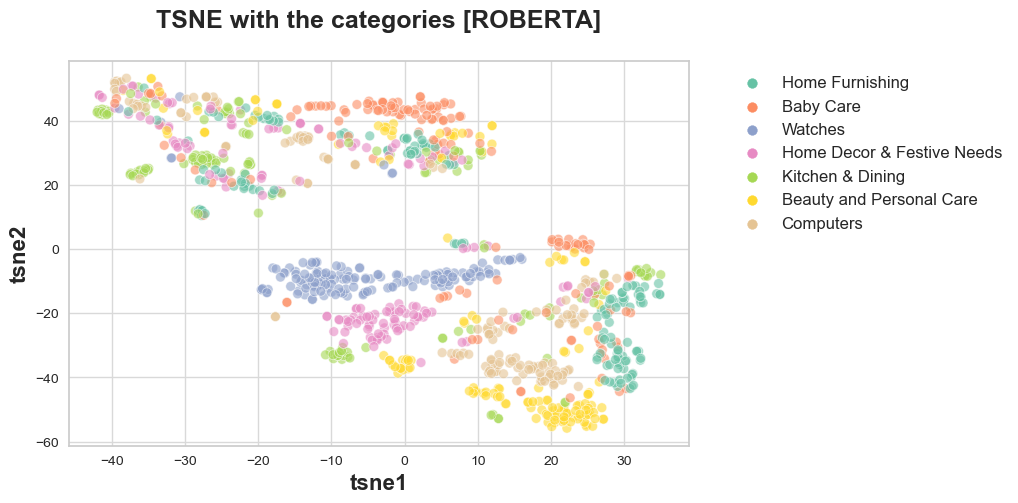

In [306]:
df_tsne_roberta = utils.get_tsne_reduced_dataframe(feat_pca_roberta)
utils.display_tsne_categories(df_tsne_roberta, df_to_process['category_0'], 'ROBERTA')

We don't observe a clear enough separation between different categories, let's confirm it with the clustering score.

ARI :  0.1839


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

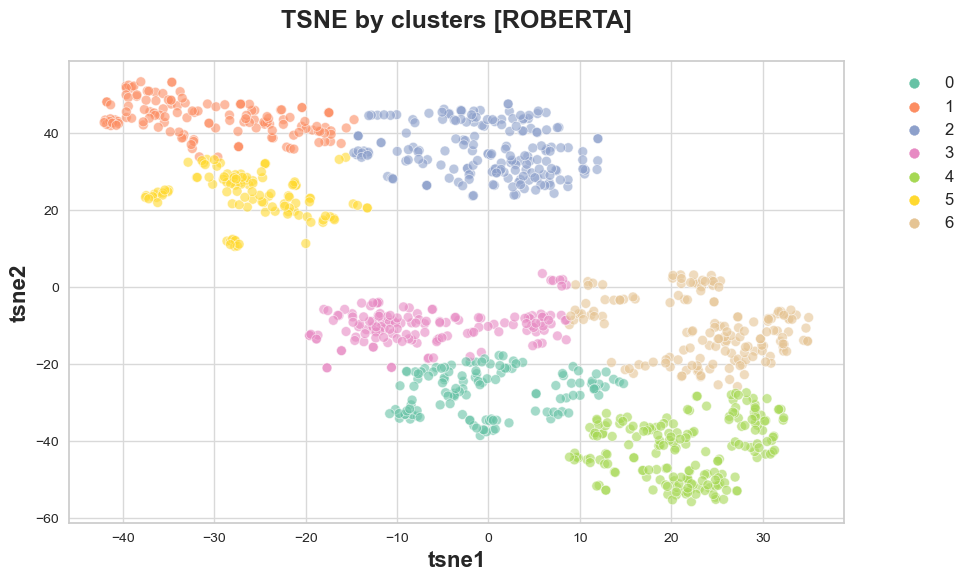

In [307]:
utils.perform_clustering(df_tsne_roberta, true_labels = df_to_process["category_0_label"], method_name='ROBERTA')

For the moment this is the lowest score we could obtain from all the methods we tested.

### USE

**Universal Sentence Encoder** encodes entire sentence or text into vectors of real numbers that can be used for clustering, sentence similarity, text classification, and other NLP tasks. 


The model is available to via the Tensorflow Hub.

Load the pre-trained USE model:

In [380]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [381]:
use_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x2f736c9d0>

Then we will generate embeddings for our documents list. This is as simple as just passing the list to the model:

In [382]:
start = time.time()

features_use = use_model(df_to_process['description_processed_3'].to_list())

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

features_use

execution time: 0.2766 seconds


<tf.Tensor: shape=(1050, 512), dtype=float32, numpy=
array([[-0.05110104, -0.05144482,  0.01383961, ...,  0.04022034,
         0.048516  ,  0.0158398 ],
       [-0.04389047, -0.00195715, -0.02649419, ...,  0.03154325,
         0.05372116,  0.02607659],
       [-0.05426852, -0.02994479, -0.03851028, ...,  0.03896609,
         0.00296324, -0.0245343 ],
       ...,
       [ 0.04087017,  0.04559577,  0.05973959, ..., -0.05486848,
         0.06035574, -0.06444691],
       [ 0.0117093 ,  0.03432317,  0.05904543, ...,  0.00107489,
        -0.04824701, -0.04341351],
       [-0.03311532,  0.05699969,  0.06610578, ...,  0.02565977,
        -0.05126197, -0.04026143]], dtype=float32)>

Save the features array for further use

In [385]:
features_use_array = np.asarray(features_use)
print(features_use_array.shape)
features_use_array

(1050, 512)


array([[-0.05110104, -0.05144482,  0.01383961, ...,  0.04022034,
         0.048516  ,  0.0158398 ],
       [-0.04389047, -0.00195715, -0.02649419, ...,  0.03154325,
         0.05372116,  0.02607659],
       [-0.05426852, -0.02994479, -0.03851028, ...,  0.03896609,
         0.00296324, -0.0245343 ],
       ...,
       [ 0.04087017,  0.04559577,  0.05973959, ..., -0.05486848,
         0.06035574, -0.06444691],
       [ 0.0117093 ,  0.03432317,  0.05904543, ...,  0.00107489,
        -0.04824701, -0.04341351],
       [-0.03311532,  0.05699969,  0.06610578, ...,  0.02565977,
        -0.05126197, -0.04026143]], dtype=float32)

In [150]:
# save to npy file
np.save('./features/features_use.npy', features_use_array)

**T-SNE**

In [386]:
df_tsne_use = utils.get_tsne_reduced_dataframe(features_use)
df_tsne_use.shape

(1050, 2)

/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

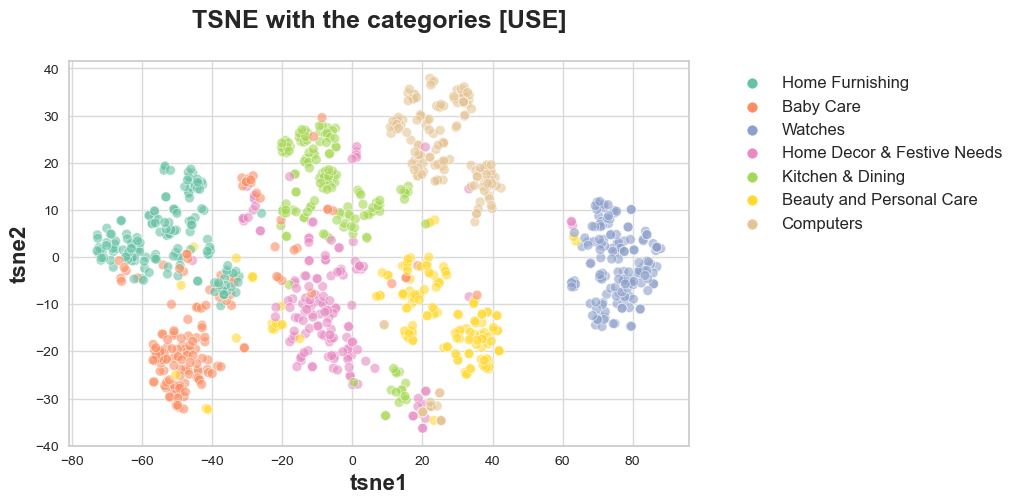

In [387]:
utils.display_tsne_categories(df_tsne_use, df_to_process['category_0'], 'USE')

The obtained cluster separation with USE is very conclusive, almost every category is well distinguished, there is however some confusion for certain items.

ARI :  0.6616


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

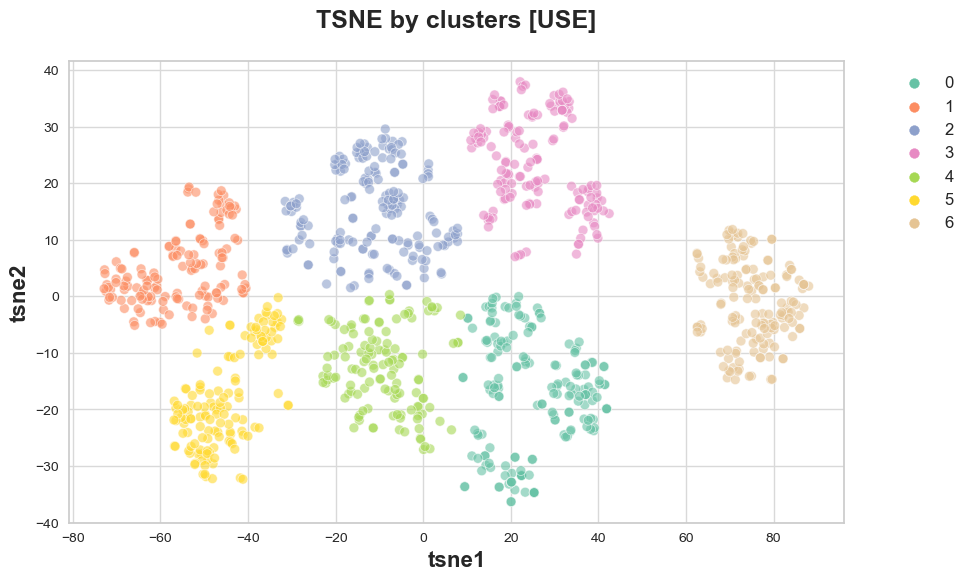

In [388]:
utils.perform_clustering(df_tsne_use, true_labels = df_to_process["category_0_label"], method_name='USE')

We obtained the best score of 0.66 with the USE model.

cluster 2: 0.48936185240745544 score
cluster 3: 0.46576207876205444 score
cluster 4: 0.5026652216911316 score
cluster 5: 0.5197386741638184 score
cluster 6: 0.527152955532074 score
cluster 7: 0.5292243361473083 score
cluster 8: 0.5280946493148804 score
cluster 9: 0.5118345618247986 score
cluster 10: 0.525715172290802 score


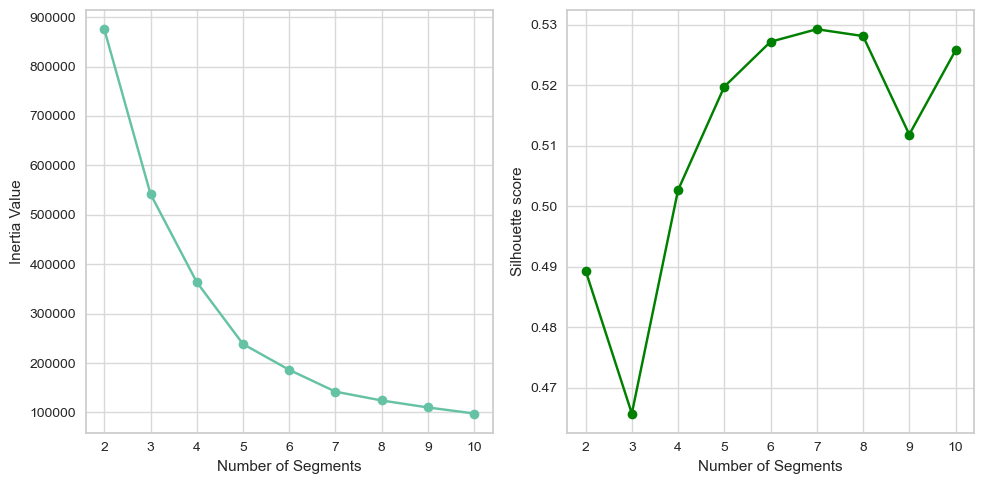

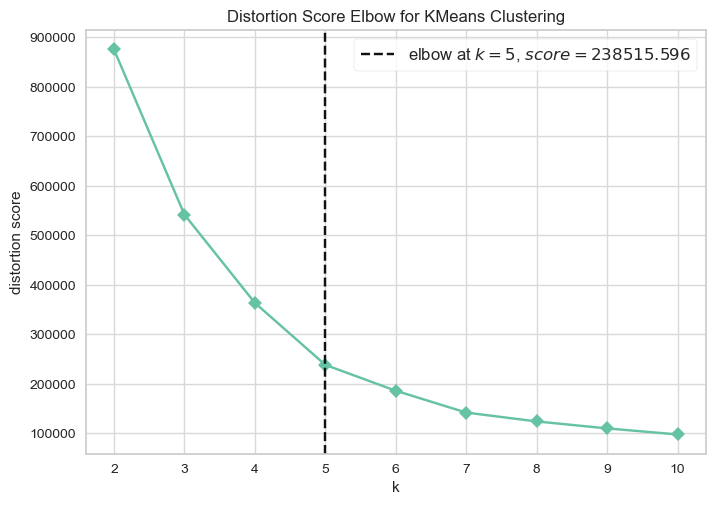

In [315]:
utils.get_cluster_scores(df_tsne_use)

We still get however the best distortion score for 5 clusters, but 7 has the best silhouette score.

# Conclusion

To sum up, here are the ARI scores obtained by different methods:

1. CountVectorizer: 0.3946
2. TF-IDF: 0.5128
3. Word2Vec: 0.4546
4. BERT: 0.3058
5. Roberta: 0.1839
6. USE: 0.6616

From the Bag of Words methods, **TF-IDF** performed really well, given its simplicity in use, performance and efficiency we can say that it can be the best choice for our use case. We can go further in trying to improve the score obtained by TF-IDF by:

- using the concept of n-grams, we can combine words in groups of 2,3,4, and so on to build our final set of features.
- tuning min_df, max_df, max_features, sublinear_tf, etc. parameters.

However, the **TF-IDF** efficiency might also be explained by a rather small vocabulary size, and it will grow as more products will be added to the dataset with a risk of creating high dimensioned sparse matrices. At this point, the computation might become very slow and expensive and it is difficult to predict it at this stage of the POC.

From the Word Embeddings techniques, **USE** demonstrates the highest result, the model adapted particularly well to our dataset.

